<a href="https://colab.research.google.com/github/jajmcallister/Little-Lost-Group/blob/main/NMA_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The equations of the dynamical system:


\begin{align} \tau_{E_1} \frac{dr_{E_1}}{dt} &= -r_{E_1} + F_{E_1}(w_{E_1E_1}r_{E_1} +w_{E_1E_2}r_{E_2} -w_{E_1I}r_I + I^{\text{ext}}_{E_1};a_{E_1},\theta_{E_1}) \qquad (1)\\ \tau_{E_2} \frac{dr_{E_2}}{dt} &= -r_{E_2} + F_{E_2}(w_{E_2E_2}r_{E_2} +w_{E_2E_1}r_{E_1} -w_{E_2I}r_I + I^{\text{ext}}_{E_2};a_{E_2},\theta_{E_2}) \qquad (2)\\ \tau_I \frac{dr_I}{dt} &= -r_I + F_I(w_{IE_1}r_{E_1} + w_{IE_2}r_{E_2} -w_{II}r_I + I^{\text{ext}}_I;a_I,\theta_I) \qquad (3) \end{align}

Assuming $r_I$ has a time constant much much smaller than the excitatory neurons

\begin{align}
r_I &= F_I(w_{IE_1}r_{E_1} + w_{IE_2}r_{E_2} -w_{II}r_I + I^{\text{ext}}_I;a_I,\theta_I) \qquad (4) \\
 \tau_{E_1} \frac{dr_{E_1}}{dt} &= -r_{E_1} + F_{E_1}(w_{E_1E_1}r_{E_1} +w_{E_1E_2}r_{E_2} -w_{E_1I}r_I + I^{\text{ext}}_{E_1};a_{E_1},\theta_{E_1}) \qquad (5)\\ \tau_{E_2} \frac{dr_{E_2}}{dt} &= -r_{E_2} + F_{E_2}(w_{E_2E_2}r_{E_2} +w_{E_2E_1}r_{E_1} -w_{E_2I} r_I  + I^{\text{ext}}_{E_2};a_{E_2},\theta_{E_2}) \qquad (6)
 \end{align}

Assuming the input-output curve of the inhibitory population is linear:

\begin{aligned}
r_I = \frac{\gamma (w_{IE_1}r_{E_1}+w_{IE_2}r_{E_2}+I_I^{ext})}{1+\gamma w_{II}}
\end{aligned}

# **Imports**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt  # root-finding algorithm
import scipy

# **Figure settings**

In [ ]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

# **Plotting and Helper functions**

In [ ]:
def default_pars(**kwargs):
  pars = {}

 # Excitatory parameters
  pars['tau_E1'] = 1.     # Timescale of the E1 population [ms]
  pars['a_E1'] = 1.2      # Gain of the E1 population
  pars['theta_E1'] = 2.8  # Threshold of the E1 population
  pars['tau_E2'] = 1.     # Timescale of the E2 population [ms]
  pars['a_E2'] = 1.2      # Gain of the E2 population
  pars['theta_E2'] = 2.8  # Threshold of the E2 population

  # Inhibitory parameters
  pars['tau_I'] = 2.0    # Timescale of the I population [ms]
  pars['a_I'] = 1.0      # Gain of the I population
  pars['theta_I'] = 4.0  # Threshold of the I population
  pars['gamma'] = 1.5     # Slope of the linear input-output function

  # Connection strength
  pars['wE1E1'] = 9.   # E1 to E1
  pars['wE2E2'] = 9.   # E2 to E2
  pars['wE1E2'] = 0    # E1 to E2
  pars['wE2E1'] = 0    # E2 to E0
  pars['wE1I'] = 1.8   # I to E1
  pars['wE2I'] = 1.8   # I to E2
  pars['wIE1'] = 2.  # E1 to I
  pars['wIE2'] = 2  # E2 to I
  pars['wII'] = 0.  # I to I

  # External input
  pars['I_ext_E1'] = 1.6
  pars['I_ext_E2'] = 1.6
  pars['I_ext_I'] = 0.

  # simulation parameters
  pars['T'] = 50.        # Total duration of simulation [ms]
  pars['dt'] = .01        # Simulation time step [ms]
  pars['rE1_init'] = 0.5  # Initial value of E1
  pars['rE2_init'] = 0.5  # Initial value of E2
  pars['rI_init'] = 0.2  # Initial value of I

  #STP parameters
  pars['tau_s'] = 100     #time constant of s, as per paper
  pars['tau_u'] = 650     #time constant of u, idem
  pars['tau_x'] = 150     #time constant of x, idem
  pars['U'] = 0.5         #Increment of s produced by a spike
  pars['x_init'] = 1      #Initial value of x
  pars['u_init'] = 0      #initial value of u
  pars['s_init'] = 0.5

  # External parameters if any
  for k in kwargs:
      pars[k] = kwargs[k]

  # Vector of discretized time points [ms]
  pars['range_t'] = np.arange(0, pars['T'], pars['dt'])

  return pars


def F(x, a, theta):
  """
  Population activation function, F-I curve

  Args:
    x     : the population input
    a     : the gain of the function
    theta : the threshold of the function

  Returns:
    f     : the population activation response f(x) for input x
  """

  # add the expression of f = F(x)
  f = (1 + np.exp(-a * (x - theta)))**-1 - (1 + np.exp(a * theta))**-1

  return f


def dF(x, a, theta):
  """
  Derivative of the population activation function.

  Args:
    x     : the population input
    a     : the gain of the function
    theta : the threshold of the function

  Returns:
    dFdx  :  Derivative of the population activation function.
  """

  dFdx = a * np.exp(-a * (x - theta)) * (1 + np.exp(-a * (x - theta)))**-2

  return dFdx

##############################

def plot_FI_inverse(x, a, theta):
  f, ax = plt.subplots()
  ax.plot(x, F_inv(x, a=a, theta=theta))
  ax.set(xlabel="$x$", ylabel="$F^{-1}(x)$")


def plot_FI_EI(x, FI_exc1, FI_exc2, FI_inh):
  plt.figure()
  plt.plot(x, FI_exc1, 'b', label='E1 population')
  plt.plot(x, FI_exc2, 'b', label='E2 population')
  plt.plot(x, FI_inh, 'r', label='I population')
  plt.legend(loc='lower right')
  plt.xlabel('x (a.u.)')
  plt.ylabel('F(x)')
  plt.show()


def my_test_plot(t, rE1, rI1, rE2, rI2):

  plt.figure()
  ax1 = plt.subplot(211)
  ax1.plot(pars['range_t'], rE1, 'b', label='E1 population')
  ax1.plot(pars['range_t'], rE2, 'g', label='E2 population')
  ax1.plot(pars['range_t'], rI1, 'r', label='I population')
  ax1.set_ylabel('Activity')
  ax1.legend(loc='best')

  ax2 = plt.subplot(212, sharex=ax1, sharey=ax1)
  ax2.plot(pars['range_t'], rE1, 'b', label='E1 population')
  ax2.plot(pars['range_t'], rE2, 'g', label='E2 population')
  ax2.plot(pars['range_t'], rI2, 'r', label='I population')
  ax2.set_xlabel('t (ms)')
  ax2.set_ylabel('Activity')
  ax2.legend(loc='best')

  plt.tight_layout()
  plt.show()


def plot_nullclines(Exc_null_rE, Exc_null_rI, Inh_null_rE, Inh_null_rI):

  plt.figure()
  plt.plot(Exc_null_rE, Exc_null_rI, 'r', label='E1 nullcline')
  plt.plot(Inh_null_rE, Inh_null_rI, 'g', label='E2 nullcline')
  plt.xlabel(r'$r_E1$')
  plt.ylabel(r'$r_E2$')
  plt.legend(loc='best')
  plt.show()

def my_plot_nullcline(pars):
  Exc1_null_rE1 = np.linspace(-0.2, 0.96, 1000)
  Exc1_null_rE2 = get_E1_nullcline(Exc1_null_rE1, **pars)
  Exc2_null_rE2 = np.linspace(-.2, 0.96, 1000)
  Exc2_null_rE1 = get_E2_nullcline(Exc2_null_rE2, **pars)

  # Compute nullclines
  plt.plot(Exc1_null_rE1, Exc1_null_rE2, 'r', label='E1 nullcline')
  plt.plot(Exc2_null_rE1, Exc2_null_rE2, 'g', label= 'E2 nullcline')
  plt.xlabel(r'$r_E1$')
  plt.ylabel(r'$r_E2$')
  plt.legend(loc='best')


def my_plot_vector(pars, my_n_skip=2, myscale=5): #need to work on this?
  EI_grid = np.linspace(0., 1., 20)
  rE, rI = np.meshgrid(EI_grid, EI_grid)
  drEdt, drIdt = EIderivs(rE, rI, **pars)

  n_skip = my_n_skip

  plt.quiver(rE[::n_skip, ::n_skip], rI[::n_skip, ::n_skip],
             drEdt[::n_skip, ::n_skip], drIdt[::n_skip, ::n_skip],
             angles='xy', scale_units='xy', scale=myscale, facecolor='c')

  plt.xlabel(r'$r_E$')
  plt.ylabel(r'$r_I$')


def my_plot_trajectory(pars, mycolor, x_init, mylabel):
  pars = pars.copy()
  pars['rE1_init'], pars['rE2_init'], pars['rI_init'] = x_init[0], x_init[1], x_init[2]
  rE1_tj, rE2_tj, rI_tj = simulate_wc(**pars)

  plt.plot(rE1_tj, rE2_tj, color=mycolor, label=mylabel)
  plt.plot(x_init[0], x_init[1], x_init[2], 'o', color=mycolor, ms=8)
  plt.xlabel(r'$r_E$')
  plt.ylabel(r'$r_I$')


def my_plot_trajectories(pars, dx, n, mylabel):
  """
  Solve for I along the E_grid from dE/dt = 0.

  Expects:
  pars    : Parameter dictionary
  dx      : increment of initial values
  n       : n*n trjectories
  mylabel : label for legend

  Returns:
    figure of trajectory
  """
  pars = pars.copy()
  for ie in range(n):
    for ii in range(n):
      pars['rE1_init'], pars['rE2_init'] = dx * ie, dx * ii
      rE1_tj, rE2_tj,_ = simulate_wc(**pars)
      if (ie == n-1) & (ii == n-1):
          plt.plot(rE1_tj, rE2_tj, 'gray', alpha=0.8, label=mylabel)
      else:
          plt.plot(rE1_tj, rE2_tj, 'gray', alpha=0.8)

  plt.xlabel(r'$r_E1$')
  plt.ylabel(r'$r_E2$')


def plot_complete_analysis(pars):
  plt.figure(figsize=(7.7, 6.))

  # plot example trajectories
  my_plot_trajectories(pars, 0.2, 6,
                        'Sample trajectories \nfor different init. conditions')
  # my_plot_trajectory(pars, 'm', [0.6, 0.6, 0.8],
  #                    'Sample trajectory for \nlow activity')
  # my_plot_trajectory(pars, 'orange', [0.6, 0.6, 0.6],
  #                    'Sample trajectory for \nhigh activity')

  # plot nullclines
  my_plot_nullcline(pars)

  # plot vector field
  EI_grid = np.linspace(0., 1., 20)
  rE1, rE2 = np.meshgrid(EI_grid, EI_grid)
  drE1dt, drE2dt = EIderivs(rE1, rE2, **pars)
  n_skip = 2
  plt.quiver(rE1[::n_skip, ::n_skip], rE2[::n_skip, ::n_skip],
             drE1dt[::n_skip, ::n_skip], drE2dt[::n_skip, ::n_skip],
             angles='xy', scale_units='xy', scale=5., facecolor='c')
  plt.xlim(-0.05,1)
  plt.ylim(-0.05,1)
  plt.legend(loc=[1.02, 0.57], handlelength=1)
  plt.show()


def plot_fp(x_fp, position=(0.02, 0.1), rotation=0):
  plt.plot(x_fp[0], x_fp[1], 'ko', ms=8)
  plt.text(x_fp[0] + position[0], x_fp[1] + position[1],
           f'Fixed Point1=\n({x_fp[0]:.3f}, {x_fp[1]:.3f})',
           horizontalalignment='center', verticalalignment='bottom',
           rotation=rotation)



# **Some simulations**

Simulation scheme for the Wilson-Cowan model

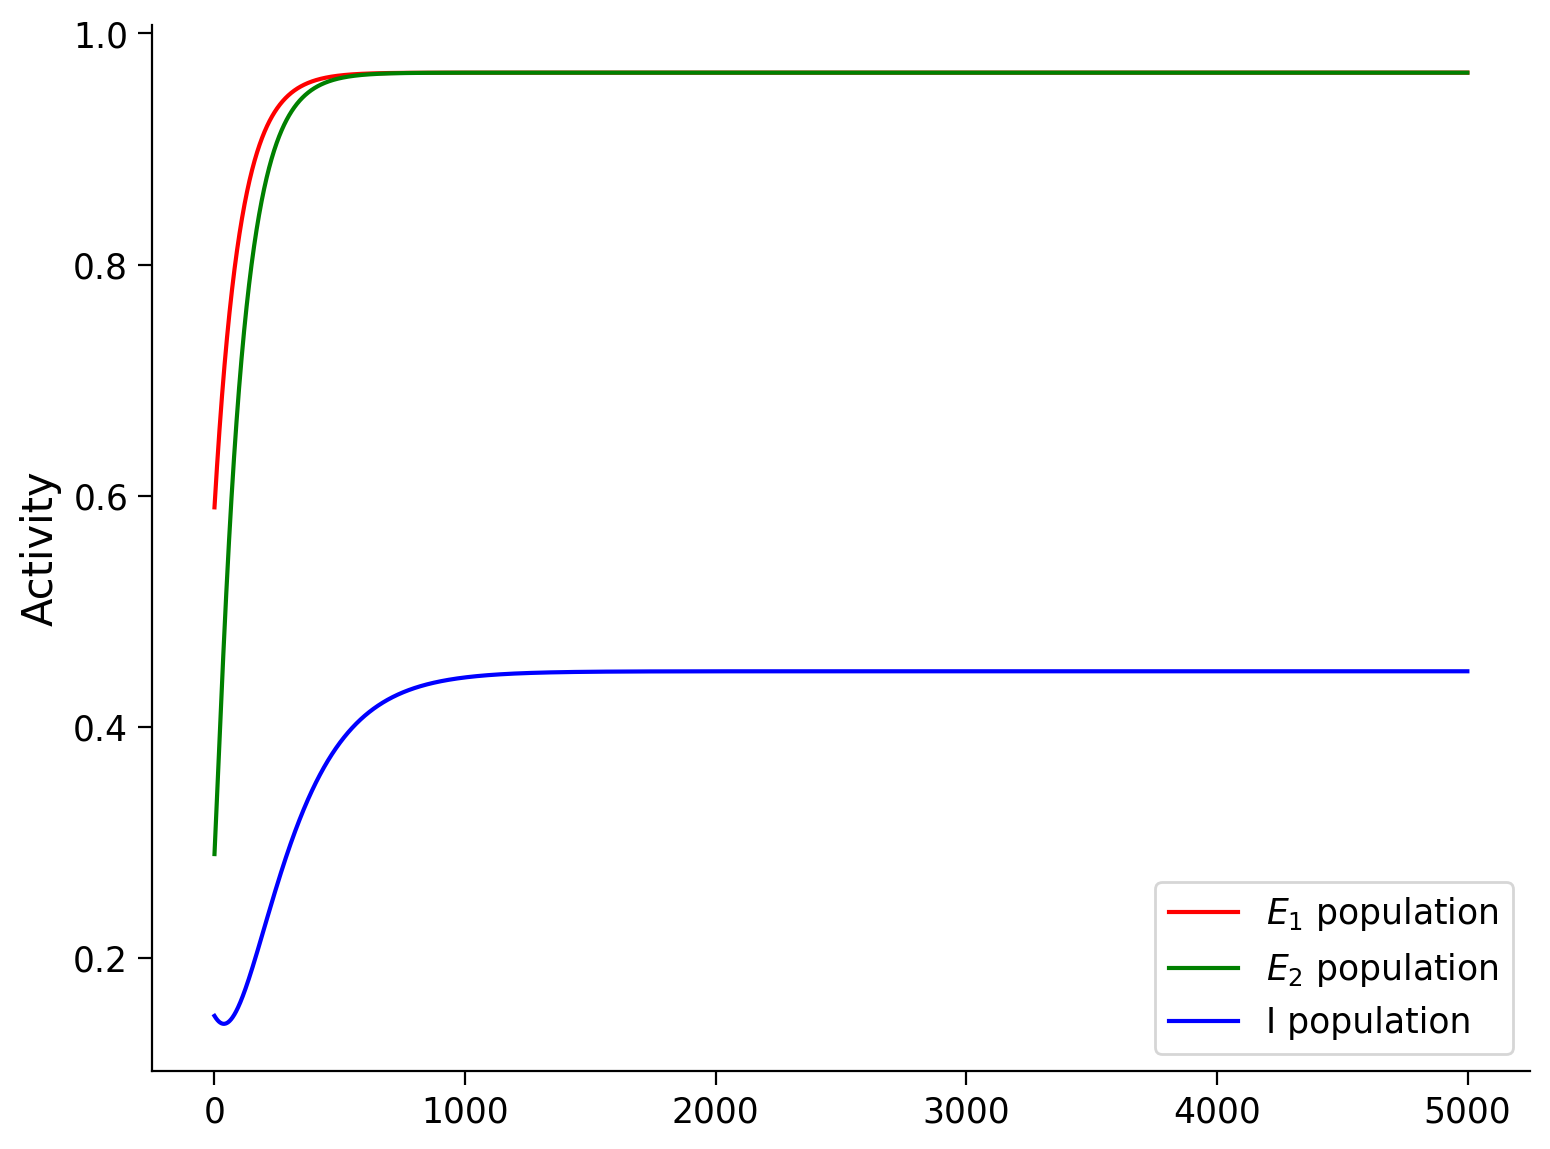

In [ ]:
def simulate_wc(tau_E1, a_E1, theta_E1, tau_E2, a_E2, theta_E2, tau_I, a_I, theta_I,
                wE1E1, wE2E2, wE1E2, wE2E1, wE1I, wE2I, wIE1, wIE2, wII, I_ext_E1, I_ext_E2, I_ext_I,
                rE1_init, rE2_init, rI_init, dt, range_t, **other_pars):
  """
  Simulate the Wilson-Cowan equations

  Args:
    Parameters of the Wilson-Cowan model

  Returns:
    rE1, rE2, rI (arrays) : Activity of excitatory and inhibitory populations
  """
  # Initialize activity arrays
  Lt = range_t.size
  rE1 = np.append(rE1_init, np.zeros(Lt - 1))
  rE2 = np.append(rE2_init, np.zeros(Lt - 1))
  rI = np.append(rI_init, np.zeros(Lt - 1))
  I_ext_E1 = I_ext_E1 * np.ones(Lt)
  I_ext_E2 = I_ext_E2 * np.ones(Lt)
  I_ext_I = I_ext_I * np.ones(Lt)

  # Simulate the Wilson-Cowan equations
  for k in range(Lt - 1):

    # Calculate the derivative of the E1 population
    drE1 = dt / tau_E1 * (-rE1[k] + F(wE1E1 * rE1[k] + wE1E2 * rE2[k] - wE1I * rI[k] + I_ext_E1[k],
                                   a_E1, theta_E1))

    # Calculate the derivative of the E2 population
    drE2 = dt / tau_E2 * (-rE2[k] + F(wE2E2 * rE2[k] + wE2E1 * rE1[k] - wE2I * rI[k] + I_ext_E2[k],
                                   a_E2, theta_E2))

    # Calculate the derivative of the I population
    drI = dt / tau_I * (-rI[k] + F(wIE1 * rE1[k] + wIE2 * rE2[k] - wII * rI[k] + I_ext_I[k],
                                   a_I, theta_I))

    # Update using Euler's method
    rE1[k + 1] = rE1[k] + drE1
    rE2[k + 1] = rE2[k] + drE2
    rI[k + 1] = rI[k] + drI

  return rE1, rE2, rI


pars = default_pars()

# Simulate a trajectory
rE1, rE2, rI = simulate_wc(**default_pars(rE1_init=0.59, rE2_init=.29, rI_init=.15))

plt.figure()
plt.plot(rE1, 'r', label = '$E_1$ population')
plt.plot(rE2, 'g', label = '$E_2$ population')
plt.plot(rI, 'b', label = 'I population')
plt.ylabel('Activity')
plt.legend()
plt.show()


**Widget**

In [ ]:
@widgets.interact(
    rE1_init=widgets.FloatSlider(0.32, min=0.30, max=0.55, step=.01),
    rE2_init=widgets.FloatSlider(0.32, min=0.30, max=0.55, step=.01)
)

def plot_EI_diffinitial(rE1_init=0.0, rE2_init=0.0):

  pars = default_pars(rE1_init= rE1_init, rE2_init = rE2_init, rI_init=.15)
  rE1, rE2, rI = simulate_wc(**pars)

  plt.figure()
  plt.plot(pars['range_t'], rE1, 'r', label='E1 population')
  plt.plot(pars['range_t'], rE2, 'g', label='E2 population')
  plt.plot(pars['range_t'], rI, 'b', label='I population')
  plt.xlabel('t (ms)')
  plt.ylabel('Activity')
  plt.legend(loc='best')
  plt.show()

interactive(children=(FloatSlider(value=0.32, description='rE1_init', max=0.55, min=0.3, step=0.01), FloatSlid…

In [ ]:
@widgets.interact(
    I_ext_E1=widgets.FloatSlider(6., min=0.0, max=10., step=0.01),
    I_ext_E2=widgets.FloatSlider(6., min=0.0, max=10., step=0.01),
    wE1E1=widgets.FloatSlider(6., min=0.0, max=10., step=0.01),
    wE2E2=widgets.FloatSlider(6., min=0.0, max=10., step=0.01),
    wE1I=widgets.FloatSlider(6., min=0.01, max=10., step=0.01),
    wE2I=widgets.FloatSlider(6., min=0.01, max=10., step=0.01),
    wIE1=widgets.FloatSlider(6., min=0.01, max=10., step=0.01),
    wIE2=widgets.FloatSlider(6., min=0.01, max=10., step=0.01)
)

def plot_nullcline_diffwEE(I_ext_E1, I_ext_E2, wE1E1, wE2E2, wE1I, wE2I, wIE1, wIE2):
  """
    plot nullclines for different values of I_ext_E1, I_ext_E2, wE1E1, wE2E2, wE1I, wE2I, wIE1, wIE2
  """

  pars = default_pars(I_ext_E1=I_ext_E1, I_ext_E2=I_ext_E2, wE1E1=wE1E1, wE2E2=wE2E2, wE1I=wE1I, wE2I=wE2I, wIE1=wIE1, wIE2=wIE2)

  plt.figure(figsize=(12, 5.5))

  plt.subplot(222)
  pars['rE1_init'], pars['rE2_init'] = 0.2, 0.2
  rE1, rE2, _ = simulate_wc(**pars)
  plt.plot(pars['range_t'], rE1, 'r', label='E1 population', clip_on=False)
  plt.plot(pars['range_t'], rE2, 'g', label='E2 population', clip_on=False)
  plt.plot(pars['range_t'], rI, 'b', label='I population', clip_on=False)
  plt.ylabel('Activity')
  plt.legend(loc='best')
  plt.ylim(-0.05, 1.05)
  plt.title('E1/E2/I activity\nfor different initial conditions',
            fontweight='bold')

  plt.subplot(224)
  pars['rE1_init'], pars['rE2_init'] = 0.4, 0.1
  rE1, rE2, _ = simulate_wc(**pars)
  plt.plot(pars['range_t'], rE1, 'r', label='E1 population', clip_on=False)
  plt.plot(pars['range_t'], rE2, 'g', label='E2 population', clip_on=False)
  plt.plot(pars['range_t'], rI, 'b', label='I population', clip_on=False)
  plt.xlabel('t (ms)')
  plt.ylabel('Activity')
  plt.ylim(-0.05, 1.05)

  plt.tight_layout()
  plt.show()

interactive(children=(FloatSlider(value=6.0, description='I_ext_E1', max=10.0, step=0.01), FloatSlider(value=6…

# **Phase Plane Analysis**

In [ ]:
pars = default_pars(T=10, rE1_init=0.55, rE2_init=0.4, rI_init=0.2)
rE1, rE2, rI = simulate_wc(**pars)

@widgets.interact(
    n_t=widgets.IntSlider(0, min=0, max=len(pars['range_t']) - 1, step=1)
)


def plot_activity_phase(n_t):
  plt.figure(figsize=(8, 5.5))
  plt.subplot(211)
  plt.plot(pars['range_t'], rE1, 'r', label=r'$r_{E1}$')
  plt.plot(pars['range_t'], rE2, 'g', label=r'$r_{E2}$')
  plt.plot(pars['range_t'], rI, 'b', label=r'$r_I$')
  plt.plot(pars['range_t'][n_t], rE1[n_t], 'o')
  plt.plot(pars['range_t'][n_t], rE2[n_t], 'o')
  plt.plot(pars['range_t'][n_t], rI[n_t], 'o')
  plt.axvline(pars['range_t'][n_t], 0, 1, color='k', ls='--')
  plt.xlabel('t (ms)', fontsize=14)
  plt.ylabel('Activity', fontsize=14)
  plt.legend(loc='best', fontsize=14)

  plt.subplot(212, projection='3d')
  plt.plot(rE1, rE2, rI, 'k')
  plt.plot(rE1[n_t], rE2[n_t], rI[n_t], 'ko')
  plt.xlabel(r'$r_{E1}$', fontsize=18, color='r')
  plt.ylabel(r'$r_{E2}$', fontsize=18, color='g')

  plt.tight_layout()
  plt.show()



interactive(children=(IntSlider(value=0, description='n_t', max=999), Output()), _dom_classes=('widget-interac…

## **Defining the inverse of the transfer function F**

<ipython-input-10-6ae89296e4ae>:13: RuntimeWarning: invalid value encountered in log
  F_inverse = -1/a * np.log((x + (1 + np.exp(a * theta))**-1)**-1 - 1) + theta


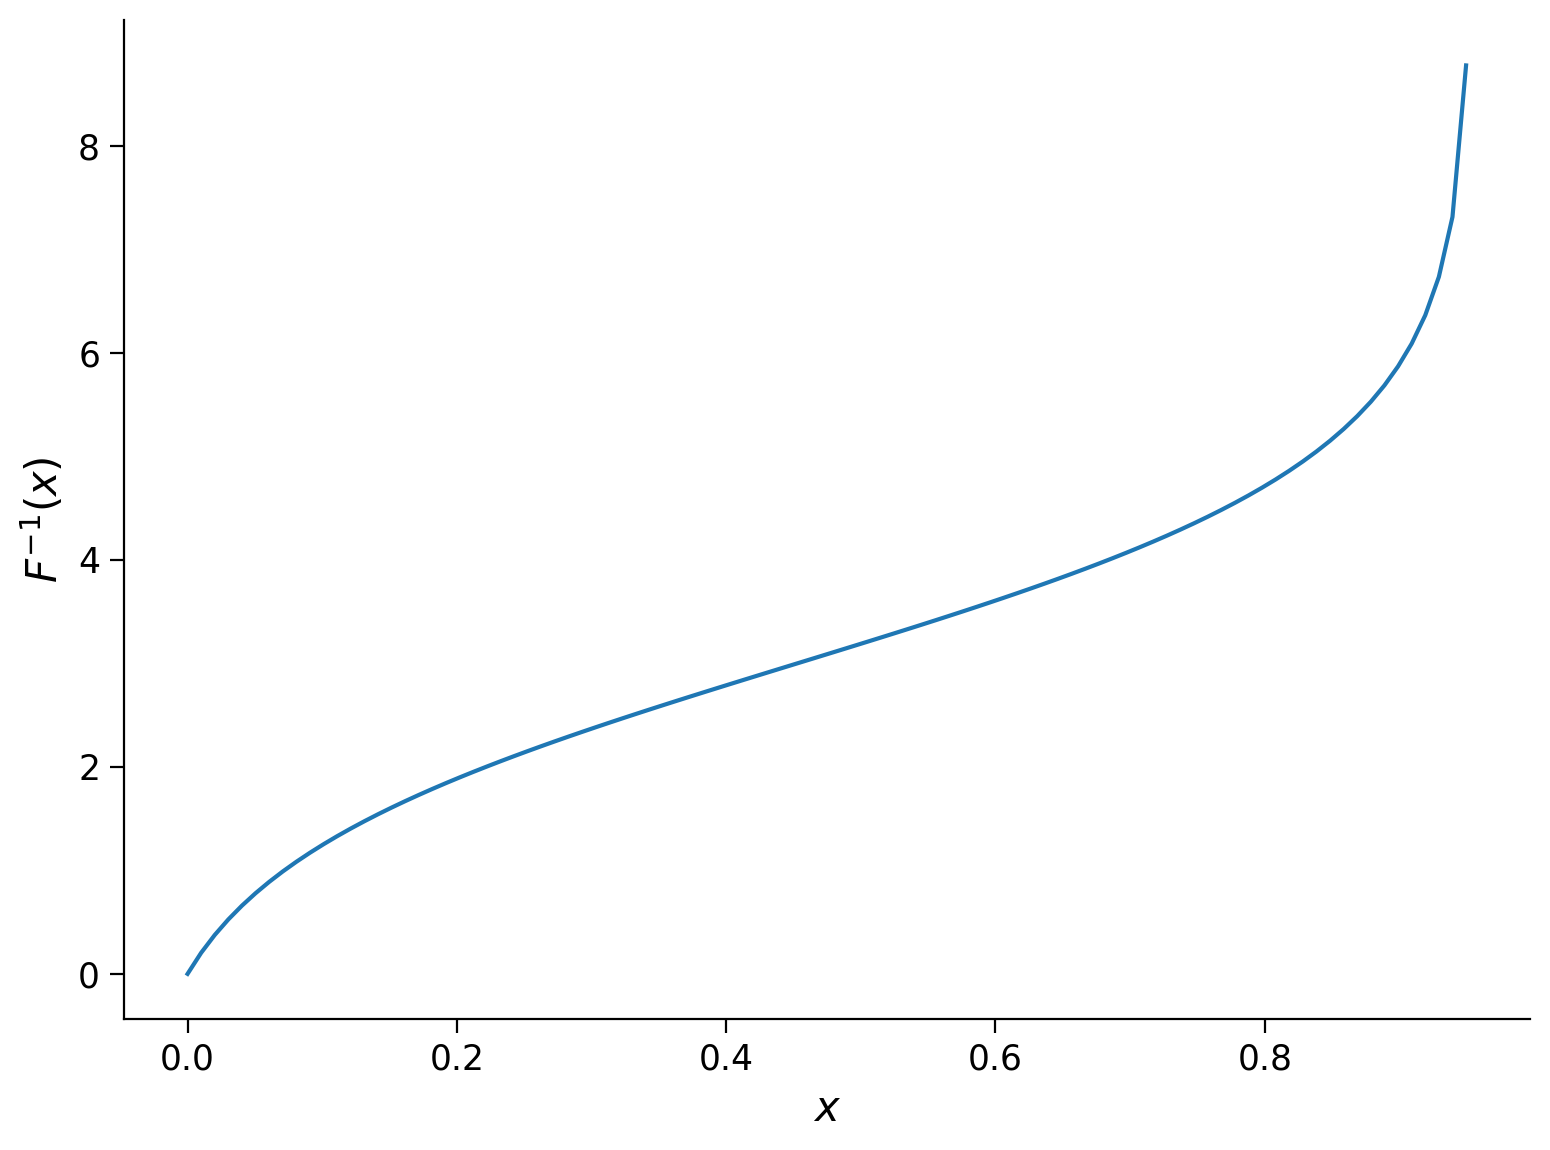

In [ ]:
def F_inv(x, a, theta):
  """
  Args:
    x         : the population input
    a         : the gain of the function
    theta     : the threshold of the function

  Returns:
    F_inverse : value of the inverse function
  """

  # Calculate Finverse (ln(x) can be calculated as np.log(x))
  F_inverse = -1/a * np.log((x + (1 + np.exp(a * theta))**-1)**-1 - 1) + theta

  return F_inverse


# Set parameters
pars = default_pars()
x = np.linspace(1e-6, 1, 100)

# Get inverse and visualize
plot_FI_inverse(x, a=1, theta=3)

# **Nullclines (defunct)**

For the first set ($r_{E1}$):

\begin{align} r_I = \frac{1}{w_{E_1 I}} [w_{E_1 E_1}r_{E_1} + w_{E_1 E_2}r_{E_2} - F^{-1} (r_{E_1}) + I_{E_1}] \\ r_{E_2} =  \frac{1}{w_{E_1 E_2}}[ F^{-1}(r_{E_1}) - w_{E_1 E_1} r_{E_1} + w_{E_1 I} r_I - I_{E_1}]  \end{align}


for $r_{E2}$:

\begin{align} r_I =& \frac{1}{w_{E_2 I}} [w_{E_2 E_2}r_{E_2} + w_{E_2 E_1}r_{E_1} - F^{-1} (r_{E_2}) + I_{E_2}] \\ r_{E_1} =&  \frac{1}{w_{E_2 E_1}}[ F^{-1}(r_{E_2}) - w_{E_2 E_2} r_{E_2} + w_{E_2 I} r_I - I_{E_2}]
\\ rE_1=&  \frac{1}{w_{E_2 E_1}}[ F^{-1}(r_{E_2}) - w_{E_2 E_2} r_{E_2} + w_{E_2 I} F_I(w_{IE_1}r_{E_1} + w_{IE_2}r_{E_2} -w_{II}r_I + I^{\text{ext}}_I) - I_{E_2}] \end{align}


for $r_{I}$:

\begin{align}  r_{E_1} =  \frac{1}{w_{I E_1}}[ F^{-1}(r_{I}) - w_{I E_2} r_{E_2} + w_{I I} r_I - I_{I}] \\ r_{E_2} =  \frac{1}{w_{I E_2}}[ F^{-1}(r_{I}) - w_{I E_1} r_{E_1} + w_{I I} r_I - I_{I}]  \end{align}

\begin{aligned}
r_I = \frac{\gamma (w_{IE_1}r_{E_1}+w_{IE_2}r_{E_2}+I_I^{ext})}{1+\gamma w_{II}}
\end{aligned}

### E1 nullcline

In [ ]:
def get_E1_I_nullcline(rE1, rE2, a_E1, theta_E1, wE1I, wE1E1, wE1E2, I_ext_E2, **other_pars):
  """
  Solve for rI along the rE2 from drE2/dt = 0.

  Args:
    rE1    : response of the 1st excitatory population
    rE2    : response of the 2nd excitatory population
    a_E1, theta_E1, wE1I, wE1E1, wE1E2, I_ext_E2 : Wilson-Cowan excitatory parameters
    Other parameters are ignored

  Returns:
    rI    : values of inhibitory population along the nullcline on the rE
  """
  # calculate rI for E nullclines on rI
  rI = (1/wE1I)*(wE1E1 *rE1 + wE1E2*rE2 - F_inv(rE1,a_E1,theta_E1) + I_ext_E1)

  return rI

def get_E1_E2_nullcline(rE1, rI, a_E1, theta_E1, wE1I, wE1E1, wE1E2, I_ext_E1, **other_pars):
  """
  Solve for rE1 along the rE2 from drE2/dt = 0.

  Args:
    rE1    : response of the 1st excitatory population
    rI     : response of the inhibitory population
    a_E1, theta_E1, wE1I, wE1E1, wE1E2, I_ext_E1 : Wilson-Cowan excitatory parameters
    Other parameters are ignored

  Returns:
    rI    : values of inhibitory population along the nullcline on the rE
  """
  # calculate rI for E nullclines on rI
  rE2 = (1/wE1E2)*(F_inv(rE1, a_E1, theta_E1) - wE1E1*rE1 + wE1I * rI - I_ext_E1)


  return rE2

def get_E1_E2_Ieq_nullcline(rE1, RI, a_E1, a_I, theta_E1, theta_I, wE1I, wE1E1, wE1E2, wIE1, wIE2, wII, I_ext_E1, I_ext_I, **other_pars):
  """
  Solve for rE1 along the rE2 from drE2/dt = 0 assuming rI is in equilibrium.

  Args:
    rE1    : response of the 1st excitatory population
    rI     : response of the inhibitory population
    a_E1, theta_E1, wE1I, wE1E1, wE1E2, I_ext_E1 : Wilson-Cowan excitatory parameters
    Other parameters are ignored

  Returns:
    rI    : values of inhibitory population along the nullcline on the rE
  """
  # calculate rI for E nullclines on rI
  rIeq = F(wIE1*rE1 + wIE2*rE2 - wII*rI * I_ext_I, a_I, theta_I)
  rE2 = (1/wE1E2)*(F_inv(rE1, a_E1, theta_E1) - wE1E1*rE1 + wE1I * rIeq - I_ext_E1)


  return rE2

def get_E1_E2_linear_nullcline(rE1, RI, a_E1, a_I, theta_E1, theta_I, wE1I, wE1E1, wE1E2, wIE1, wIE2, wII, I_ext_E1, I_ext_I, **other_pars):
  """
  Solve for rE1 along the rE2 from drE2/dt = 0 assuming input-output of inh neurons is linear and time constant of inh
  neurons is really small

  Args:
    rE1    : response of the 1st excitatory population
    rI     : response of the inhibitory population
    a_E1, theta_E1, wE1I, wE1E1, wE1E2, I_ext_E1 : Wilson-Cowan excitatory parameters
    Other parameters are ignored

  Returns:
    rI    : values of inhibitory population along the nullcline on the rE
  """
  # calculate rI for E nullclines on rI
  rI = (gamma*(wIE1*rE1 + wIE2*rE2 + I_ext_I))/(1 + gamma*wII)
  rE2 = (1/wE1E2)*(F_inv(rE1, a_E1, theta_E1) - wE1E1*rE1 + wE1I * rI - I_ext_E1)


  return rE2

### E2 nullcline

In [ ]:
def get_E2_I_nullcline(rE2, rE1, a_E2, theta_E2, wE2I, wE2E2, wE2E1, I_ext_E2, **other_pars):
  """
  Solve for rI along the rE2 from drE2/dt = 0.

  Args:
    rE1    : response of the 1st excitatory population
    rE2    : response of the 2nd excitatory population
    a_E2, theta_E2, wE2I, wE2E2, wE2E1, I_ext_E2 : Wilson-Cowan excitatory parameters
    Other parameters are ignored

  Returns:
    rI    : values of inhibitory population along the nullcline on the rE
  """
  # calculate rI for E nullclines on rI
  rI = (1/wE2I) * (wE2E2*rE2 + wE2E1*rE1  -F_inv(rE2, a_E2, theta_E2) + I_ext_E2)

  return rI

def get_E2_E1_nullcline(rE2, rI, a_E2, theta_E2, wE2I, wE2E2, wE2E1, I_ext_E2, **other_pars):
  """
  Solve for rE1 along the rE2 from drE2/dt = 0.

  Args:
    rE2    : response of the 2nd excitatory population
    rI     : response of the inhibitory population
    a_E2, theta_E2, wE2I, wE2E2, wE2E1, I_ext_E2 : Wilson-Cowan excitatory parameters
    Other parameters are ignored

  Returns:
    rI    : values of inhibitory population along the nullcline on the rE
  """
  # calculate rI for E nullclines on rI
  rE1 = (1/wE2E1) * (F_inv(rE2, a_E2, theta_E2)  -wE2E2*rE2 + wE2I*rI -I_ext_E2)

  return rE1

def get_E2_E1_Ieq_nullcline(rE2, rI, a_E2, a_I, theta_E2, theta_I, wE2I, wE2E2, wE2E1, wIE2, wII, wIE1, I_ext_E2, I_ext_I, **other_pars):
  """
  Solve for rE1 along the rE2 from drE2/dt = 0 assuming rI is in equilibrium.

  Args:
    rE2    : response of the 2nd excitatory population
    rI     : response of the inhibitory population
    a_E2, theta_E2, wE2I, wE2E2, wE2E1, I_ext_E2 : Wilson-Cowan excitatory parameters
    Other parameters are ignored

  Returns:
    rI    : values of inhibitory population along the nullcline on the rE
  """
  # calculate rI for E nullclines on rI
  rIeq = F(wIE1*rE1 + wIE2*rE2 - wII*rI * I_ext_I, a_I, theta_I)
  rE1 = (1/wE2E1) * (F_inv(rE2, a_E2, theta_E2)  -wE2E2*rE2 + wE2I*rIeq -I_ext_E2)

  return rE1


### I nullcline

In [ ]:
def get_I_E1_nullcline(rI, rE2, a_I, theta_I, wIE1, wIE2, wII, I_ext_I, **other_pars):
  """
  Solve for E1 along the rI from dI/dt = 0.

  Args:
    rI    : response of inhibitory population
    rE2   : response of the 2nd excitatory population
    a_I, theta_I, wIE1, wIE2, wII, I_ext_I : Wilson-Cowan inhibitory parameters
    Other parameters are ignored

  Returns:
    rE1    : values of the 1st excitatory population along the nullcline on the rI
  """
  # calculate rE for I nullclines on rI
  rE1 = 1 / wIE1 * (F_inv(rI, a_I, theta_I) - wIE2*rE2 +  wII*rI - I_ext_I)

  return rE1

def get_I_E2_nullcline(rI, rE2, a_I, theta_I, wIE1, wIE2, wII, I_ext_I, **other_pars):
  """
  Solve for E1 along the rI from dI/dt = 0.

  Args:
    rI    : response of inhibitory population
    rE1   : response of the 2nd excitatory population
    a_I, theta_I, wIE1, wIE2, wII, I_ext_I : Wilson-Cowan inhibitory parameters
    Other parameters are ignored

  Returns:
    rE2    : values of the 2nd excitatory population along the nullcline on the rI
  """
  # calculate rE for I nullclines on rI
  rE2 = 1 / wIE2 * (F_inv(rI, a_I, theta_I) - wIE1*rE1 + wII*rI - I_ext_I)

  return rE1

# **New work on nullclines**

\begin{align} \tau_{E_1} \frac{dr_{E_1}}{dt} &= -r_{E_1} + F_{E_1}(w_{E_1E_1}r_{E_1} +w_{E_1E_2}r_{E_2} -w_{E_1I}r_I + I^{\text{ext}}_{E_1};a_{E_1},\theta_{E_1}) \\ \tau_{E_2} \frac{dr_{E_2}}{dt} &= -r_{E_2} + F_{E_2}(w_{E_2E_2}r_{E_2} +w_{E_2E_1}r_{E_1} -w_{E_2I}r_I + I^{\text{ext}}_{E_2};a_{E_2},\theta_{E_2})\\ \end{align}

\begin{aligned}
r_I = \frac{\gamma (w_{IE_1}r_{E_1}+w_{IE_2}r_{E_2}+I_I^{ext})}{1+\gamma w_{II}}
\end{aligned}

So nullcline for Eq. 1:

\begin{align} r_{E_1} = F_{E_1}(w_{E_1E_1}r_{E_1} +w_{E_1E_2}r_{E_2} -w_{E_1I}(\frac{\gamma (w_{IE_1}r_{E_1}+w_{IE_2}r_{E_2}+I_I^{ext})}{1+\gamma w_{II}}) + I^{\text{ext}}_{E_1}) \\ F^{-1}(r_{E_1}) = w_{E_1E_1}r_{E_1} +w_{E_1 E_2}r_{E_2} -w_{E_1I}(\frac{\gamma (w_{IE_1}r_{E_1}+w_{IE_2}r_{E_2}+I_I^{ext})}{1+\gamma w_{II}}) + I^{\text{ext}}_{E_1} \\ F^{-1}(r_{E_1}) = w_{E_1E_1}r_{E_1} +w_{E_1 E_2}r_{E_2} -\frac{\gamma w_{E_1I}}{1+\gamma w_{II}}(w_{I E_1}r_{E_1}+I_I^{ext}) - \frac{\gamma w_{E_1I} w_{I E_2}}{1+\gamma w_{II}}r_{E_2} + I^{\text{ext}}_{E_1}
\end{align}

\begin{align}
w_{E_1 E_2} r_{E_2} - \frac{\gamma w_{E_1I} w_{I E_2}}{1+\gamma w_{II}}r_{E_2}= F^{-1}(r_{E_1}) - w_{E_1E_1}r_{E_1} + \frac{\gamma w_{E_1I}}{1+\gamma w_{II}}(w_{I E_1}r_{E_1}+I_I^{ext}) - I^{ext}_{E_1}
\end{align}

\begin{align}
r_{E_2} (w_{E_1 E_2} - \frac{\gamma w_{E_1I} w_{I E_2}}{1+\gamma w_{II}}) = F^{-1}(r_{E_1}) - w_{E_1E_1}r_{E_1} + \frac{\gamma w_{E_1I}}{1+\gamma w_{II}}(w_{I E_1}r_{E_1}+I_I^{ext}) - I^{ext}_{E_1}
\end{align}


\begin{align}
r_{E_2} = \frac{1}{w_{E_1 E_2} - \frac{\gamma w_{E_1I} w_{I E_2}}{1+\gamma w_{II}}}\Big(F^{-1}(r_{E_1}) - w_{E_1E_1}r_{E_1} + \frac{\gamma w_{E_1I}}{1+\gamma w_{II}}(w_{I E_1}r_{E_1}+I_I^{ext}) - I^{ext}_{E_1}\Big)
\end{align}

And nullcline for Eq. 2:

\begin{align}
r_{E_1} =  \frac{1}{w_{E_2 E_1} - \frac{\gamma w_{E_2I} w_{I E_1}}{1+\gamma w_{II}}}\Big(F^{-1}(r_{E_2}) - w_{E_2E_2}r_{E_2} + \frac{\gamma w_{E_2I}}{1+\gamma w_{II}}(w_{I E_2}r_{E_2}+I_I^{ext}) - I^{ext}_{E_2}\Big)
\end{align}

<ipython-input-10-6ae89296e4ae>:13: RuntimeWarning: invalid value encountered in log
  F_inverse = -1/a * np.log((x + (1 + np.exp(a * theta))**-1)**-1 - 1) + theta


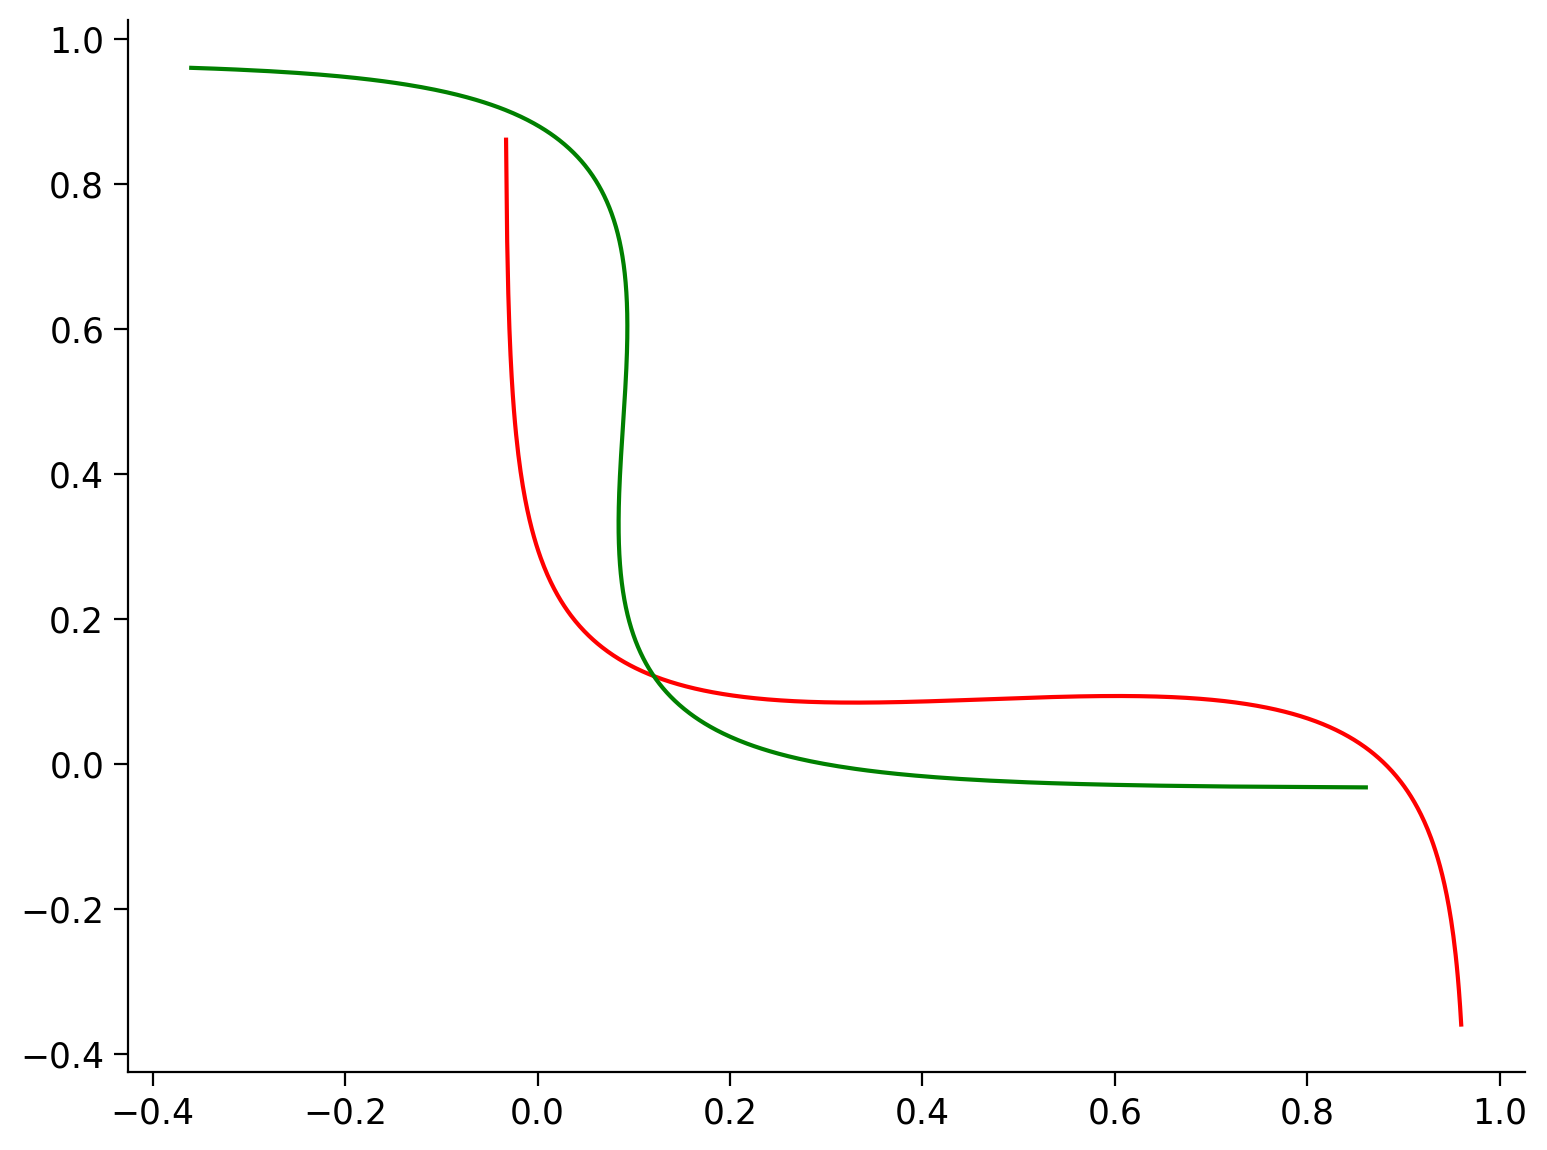

In [ ]:
def get_E1_nullcline(rE1, gamma, a_E1, theta_E1, wE1E1, wE1E2, wE2E1, wE2E2, wE1I, wE2I, wII, wIE1, wIE2, I_ext_E1, I_ext_I, **other_pars):
  """
  Solve for rE2 along the rE1 from drE1/dt = 0.

  Args:
    rE    : response of excitatory population
    a_E, theta_E, wEE, wEI, I_ext_E : Wilson-Cowan excitatory parameters
    Other parameters are ignored

  Returns:
    rI    : values of inhibitory population along the nullcline on the rE
  """
  # calculate rE2
  rE2 = (1/(wE1E2 - ((gamma * wE1I * wIE2)/(1+gamma*wII))))*(F_inv(rE1, a_E1, theta_E1)-wE1E1*rE1 + (gamma*wE1I/(1+gamma*wII))*(wIE1*rE1 + I_ext_I) - I_ext_E1)

  return rE2


def get_E2_nullcline(rE2, gamma, a_E2, theta_E2, wE1E1, wE1E2, wE2E1, wE2E2, wE1I, wE2I, wII, wIE1, wIE2, I_ext_E2, I_ext_I, **other_pars):
  """
  Solve for rE1 along the rE2 from drE2/dt = 0.

  Args:
    rI    : response of inhibitory population
    a_I, theta_I, wIE, wII, I_ext_I : Wilson-Cowan inhibitory parameters
    Other parameters are ignored

  Returns:
    rE    : values of the excitatory population along the nullcline on the rI
  """

  # calculate rE1
  rE1 = (1/(wE2E1 - ((gamma * wE2I * wIE1)/(1+gamma*wII))))*(F_inv(rE2, a_E2, theta_E2)-wE2E2*rE2 + (gamma*wE2I/(1+gamma*wII))*(wIE2*rE2 + I_ext_I) - I_ext_E2)

  return rE1


# Set parameters
pars = default_pars()
Exc1_null_rE1 = np.linspace(-0.2, 0.96, 1000)
Exc2_null_rE2 = np.linspace(-0.2, 0.96, 1000)

# Compute nullclines
Exc1_null_rE2 = get_E1_nullcline(Exc1_null_rE1, **pars)
Exc2_null_rE1 = get_E2_nullcline(Exc2_null_rE2, **pars)

# Visualize
# plot_nullclines(Exc1_null_rE1, Exc1_null_rE2, Exc2_null_rE1, Exc2_null_rE2)

plt.figure()
plt.plot(Exc1_null_rE1, Exc1_null_rE2, 'r')
plt.plot(Exc2_null_rE1, Exc2_null_rE2, 'g')
plt.show()

# Some more visualisations

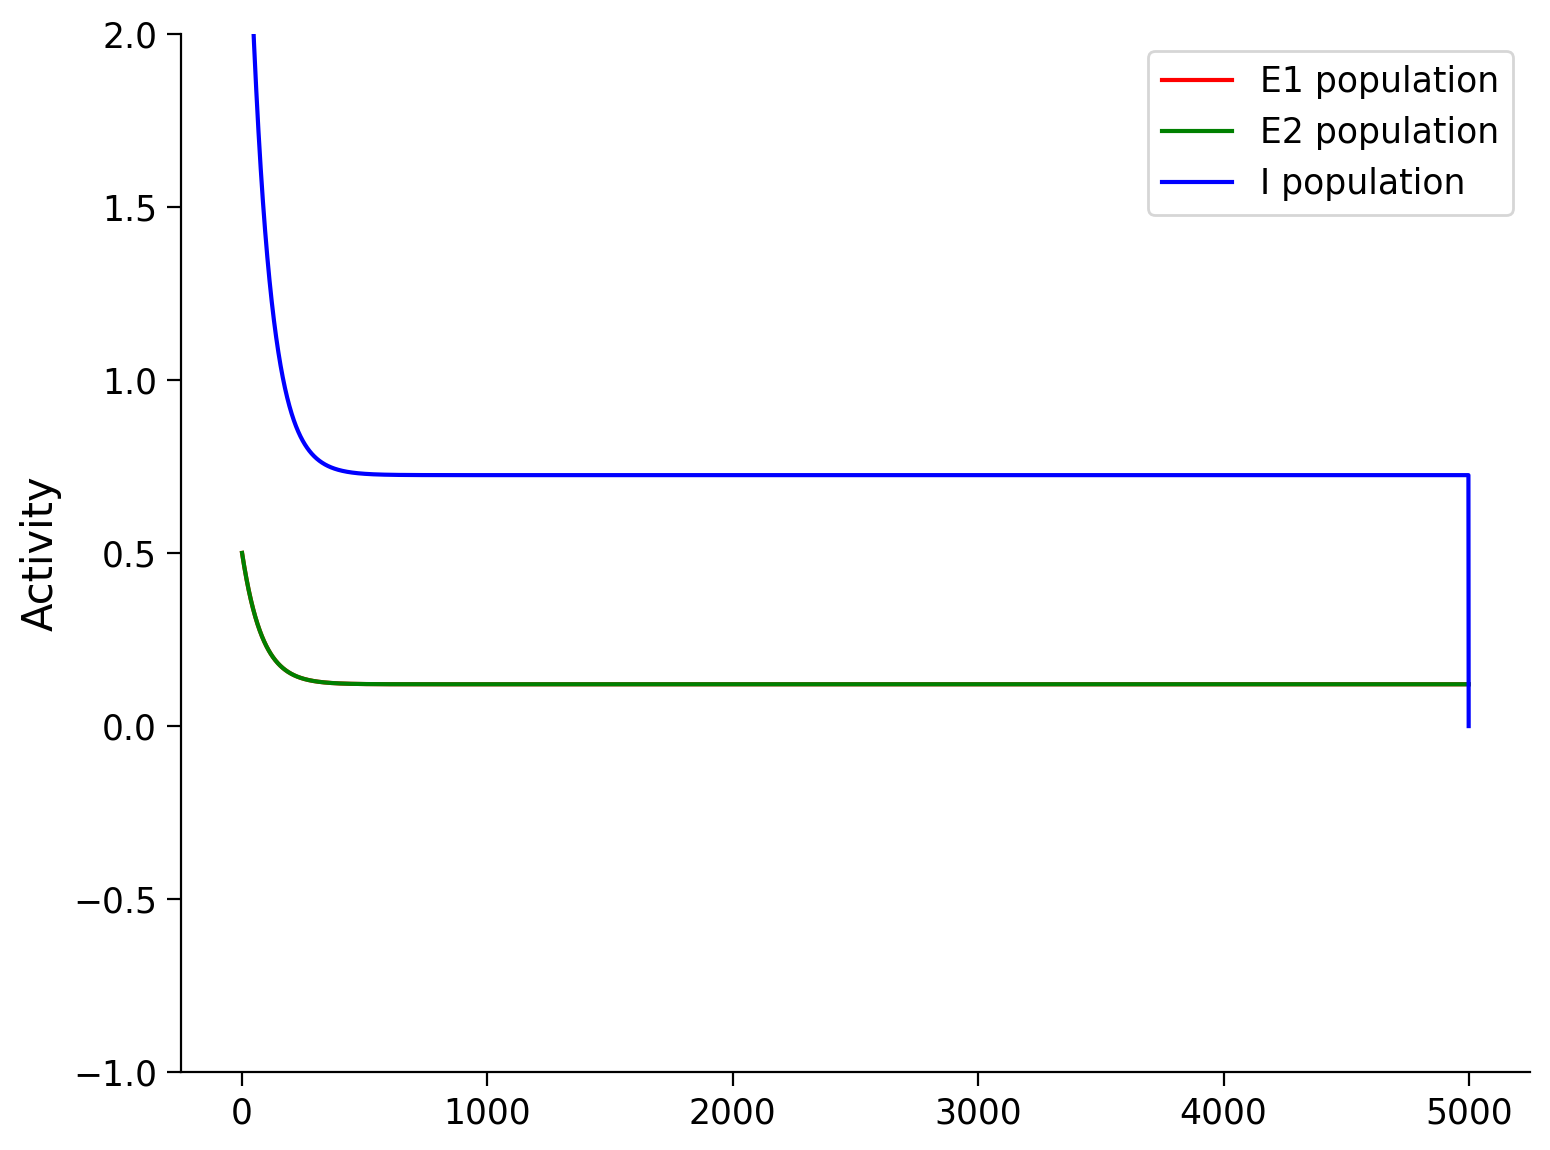

In [ ]:
def simulate_wc(tau_E1, a_E1, theta_E1, tau_E2, a_E2, theta_E2, tau_I, a_I, theta_I,
                wE1E1, wE2E2, wE1E2, wE2E1, wE1I, wE2I, wIE1, wIE2, wII, I_ext_E1, I_ext_E2, I_ext_I,
                rE1_init, rE2_init, rI_init, dt, range_t, gamma, **other_pars):
  """
  Simulate the Wilson-Cowan equations

  Args:
    Parameters of the Wilson-Cowan model

  Returns:
    rE1, rE2, rI (arrays) : Activity of excitatory and inhibitory populations
  """
  # Initialize activity arrays
  Lt = range_t.size
  rE1 = np.append(rE1_init, np.zeros(Lt - 1))
  rE2 = np.append(rE2_init, np.zeros(Lt - 1))
  rI = np.append(rI_init, np.zeros(Lt - 1))
  I_ext_E1 = I_ext_E1 * np.ones(Lt)
  I_ext_E2 = I_ext_E2 * np.ones(Lt)
  I_ext_I = I_ext_I * np.ones(Lt)

  # Simulate the Wilson-Cowan equations
  for k in range(Lt - 1):

    #update the state of the I population
    rI[k] = (gamma*(wIE1*rE1[k] + wIE2*rE2[k] + I_ext_I[k]))/(1+gamma*wII)

    # Calculate the derivative of the E1 population
    drE1 = dt / tau_E1 * (-rE1[k] + F(wE1E1 * rE1[k] + wE1E2 * rE2[k] - wE1I * rI[k] + I_ext_E1[k],
                                   a_E1, theta_E1))

    # Calculate the derivative of the E2 population
    drE2 = dt / tau_E2 * (-rE2[k] + F(wE2E2 * rE2[k] + wE2E1 * rE1[k] - wE2I * rI[k] + I_ext_E2[k],
                                   a_E2, theta_E2))


    # Update using Euler's method
    rE1[k + 1] = rE1[k] + drE1
    rE2[k + 1] = rE2[k] + drE2

  return rE1, rE2, rI


pars = default_pars()

# Simulate a trajectory
rE1, rE2, rI = simulate_wc(**default_pars())

plt.figure()
plt.plot(rE1, 'r', label = 'E1 population')
plt.plot(rE2, 'g', label = 'E2 population')
plt.plot(rI, 'b', label = 'I population')
plt.ylabel('Activity')
plt.ylim(-1, 2)
plt.legend()
plt.show()


In [ ]:
@widgets.interact(
    rE1_init=widgets.FloatSlider(0.32, min=0.30, max=0.55, step=.01),
    rE2_init=widgets.FloatSlider(0.32, min=0.30, max=0.55, step=.01)
)

def plot_EI_diffinitial(rE1_init=0.0, rE2_init=0.0):

  pars = default_pars(rE1_init= rE1_init, rE2_init = rE2_init, rI_init=.15)
  rE1, rE2, rI = simulate_wc(**pars)

  plt.figure()
  plt.plot(pars['range_t'], rE1, 'r', label='E1 population')
  plt.plot(pars['range_t'], rE2, 'g', label='E2 population')
  plt.plot(pars['range_t'], rI, 'b', label='I population')
  plt.xlabel('t (ms)')
  plt.ylabel('Activity')
  plt.ylim(-1,2)
  plt.legend(loc='best')
  plt.show()


interactive(children=(FloatSlider(value=0.32, description='rE1_init', max=0.55, min=0.3, step=0.01), FloatSlid…

# **Vector Field**

\begin{align} \tau_{E_1} \frac{dr_{E_1}}{dt} &= -r_{E_1} + F_{E_1}(w_{E_1E_1}r_{E_1} +w_{E_1E_2}r_{E_2} -w_{E_1I}r_I + I^{\text{ext}}_{E_1};a_{E_1},\theta_{E_1}) \qquad (1)\\ \tau_{E_2} \frac{dr_{E_2}}{dt} &= -r_{E_2} + F_{E_2}(w_{E_2E_2}r_{E_2} +w_{E_2E_1}r_{E_1} -w_{E_2I}r_I + I^{\text{ext}}_{E_2};a_{E_2},\theta_{E_2}) \end{align}

<ipython-input-10-6ae89296e4ae>:13: RuntimeWarning: invalid value encountered in log
  F_inverse = -1/a * np.log((x + (1 + np.exp(a * theta))**-1)**-1 - 1) + theta


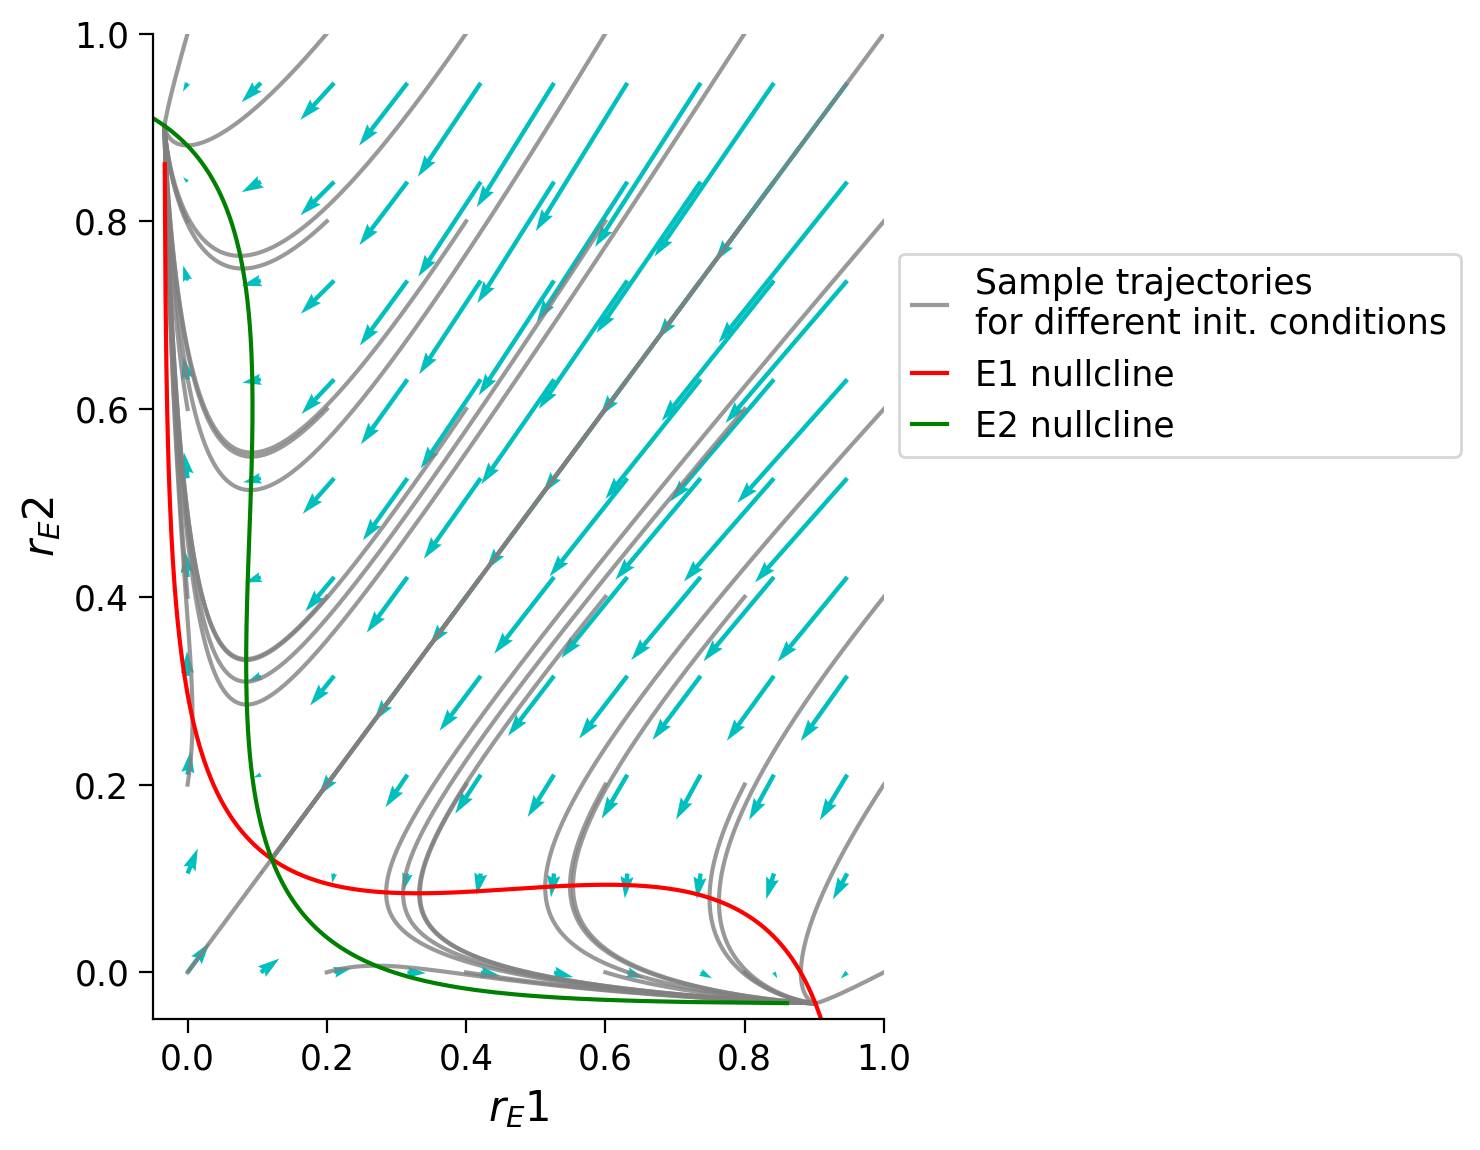

In [ ]:
def EIderivs(rE1, rE2,
             tau_E1, tau_E2, a_E1, a_E2, theta_E1, theta_E2, gamma, wE1E1, wE2E2, wE1E2, wE2E1, wE1I, wE2I, I_ext_E1, I_ext_E2,
             tau_I, a_I, theta_I, wIE1, wIE2, wII, I_ext_I,
             **other_pars):
  """Time derivatives for E/I variables (dE/dt, dI/dt)."""

  rI = (gamma*(wIE1*rE1 + wIE2*rE2 + I_ext_I))/(1+gamma*wII)
  # Compute the derivative of rE1
  drE1dt = (-rE1 + F(wE1E1 * rE1 + wE1E2 * rE2 - wE1I * rI + I_ext_E1, a_E1, theta_E1))/tau_E1

  # Compute the derivative of rE2
  drE2dt = (-rE2 + F(wE2E2 * rE2 + wE2E1 * rE1 - wE2I * rI + I_ext_E2, a_E2, theta_E2))/tau_E2

  return drE1dt, drE2dt



# Create vector field using EIderivs
plot_complete_analysis(default_pars())

# **Fixed Points**

<ipython-input-10-6ae89296e4ae>:13: RuntimeWarning: invalid value encountered in log
  F_inverse = -1/a * np.log((x + (1 + np.exp(a * theta))**-1)**-1 - 1) + theta


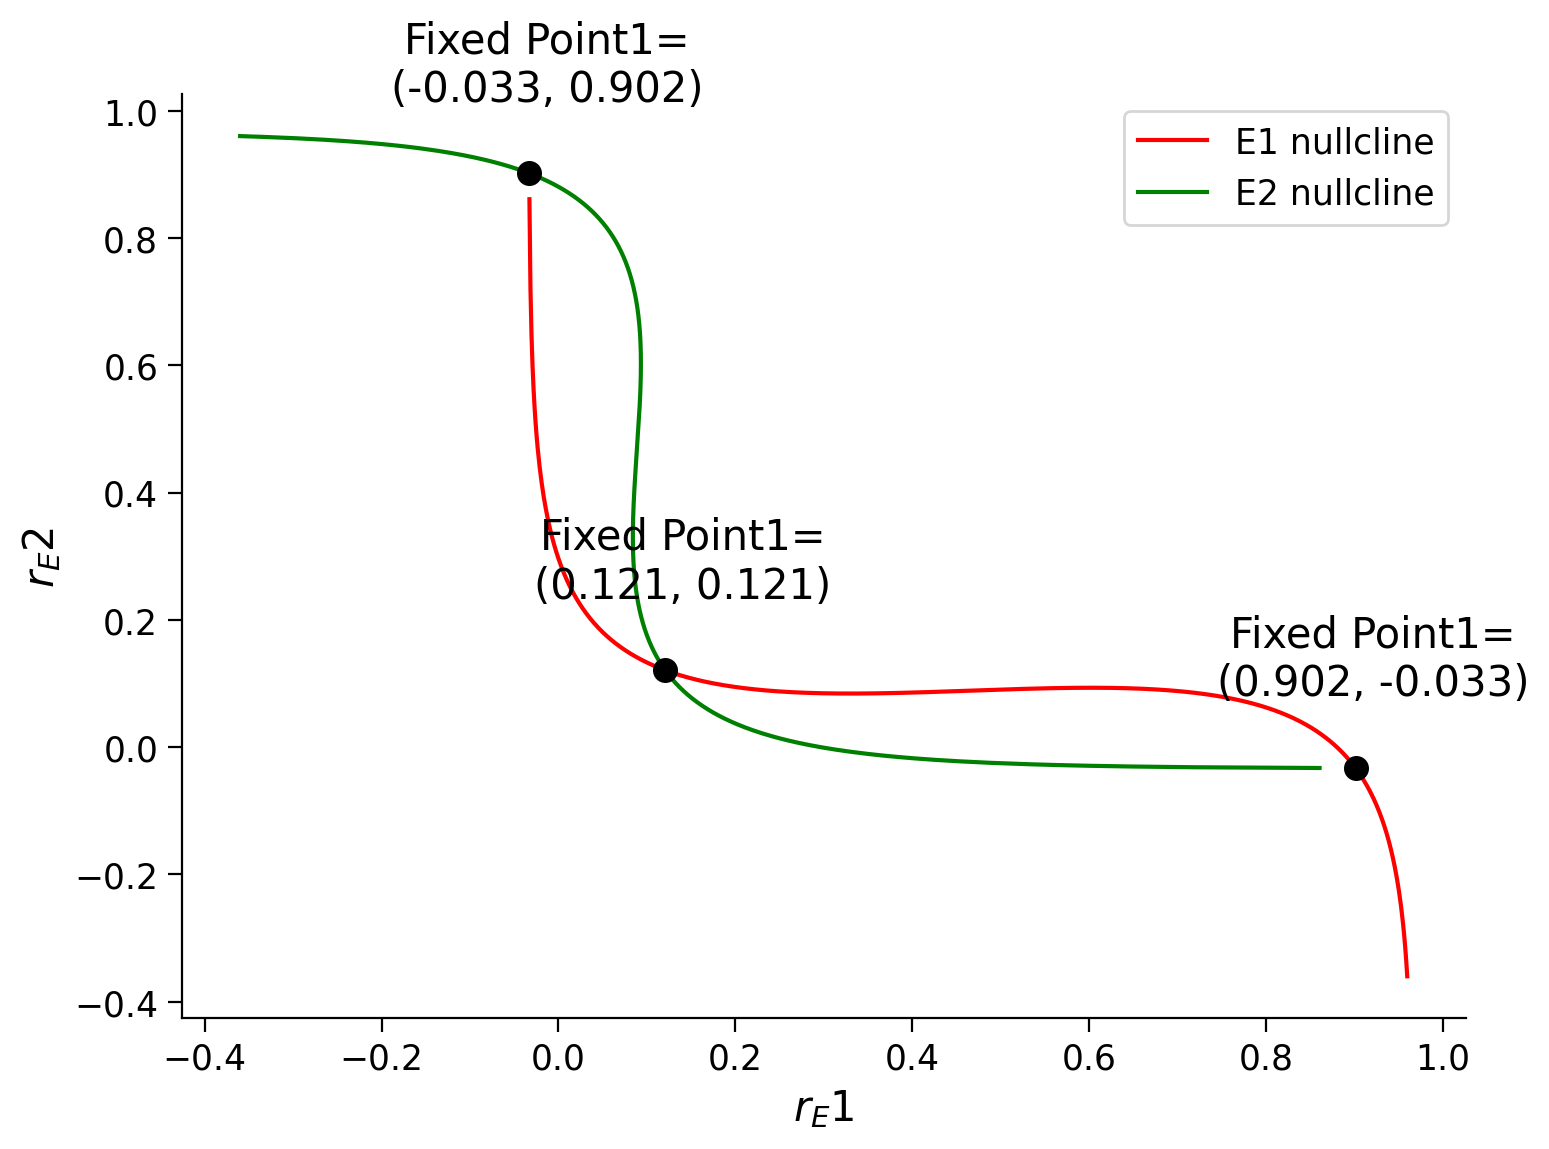

In [ ]:
def my_fp(pars, rE1_init, rE2_init):
  """
  Use opt.root function to solve Equations (2)-(3) from initial values
  """

  tau_E1, a_E1, theta_E1 = pars['tau_E1'], pars['a_E1'], pars['theta_E1']
  tau_E2, a_E2, theta_E2 = pars['tau_E2'], pars['a_E2'], pars['theta_E2']
  wE1E1, wE1E2 = pars['wE1E1'], pars['wE1E2']
  wE2E1, wE2E2 = pars['wE2E1'], pars['wE2E2']
  I_ext_E1, I_ext_E2, I_ext_I = pars['I_ext_E1'], pars['I_ext_E2'], pars['I_ext_I']
  gamma = pars['gamma']
  wIE1, wIE2, wII, wE1I, wE2I = pars['wIE1'],pars['wIE2'],pars['wII'], pars['wE1I'], pars['wE2I']


  # define the right hand of wilson-cowan equations
  def my_WCr(x):

    rE1, rE2 = x
    rI = (gamma*(wIE1*rE1 + wIE2*rE2 + I_ext_I))/(1+gamma*wII)
    drE1dt = (-rE1 + F(wE1E1 * rE1 + wE1E2 * rE2 - wE1I * rI + I_ext_E1, a_E1, theta_E1))/tau_E1
    drE2dt = (-rE2 + F(wE2E2 * rE2 + wE2E1 * rE1 - wE2I * rI + I_ext_E2, a_E2, theta_E2))/tau_E2
    y = np.array([drE1dt, drE2dt])

    return y

  x0 = np.array([rE1_init, rE2_init])
  x_fp = opt.root(my_WCr, x0).x

  return x_fp


def check_fp(pars, x_fp, mytol=1e-6):
  """
  Verify (drE/dt)^2 + (drI/dt)^2< mytol

  Args:
    pars    : Parameter dictionary
    fp      : value of fixed point
    mytol   : tolerance, default as 10^{-6}

  Returns :
    Whether it is a correct fixed point: True/False
  """

  drE1dt, drE2dt = EIderivs(x_fp[0], x_fp[1], **pars)

  return drE1dt**2 + drE2dt**2 < mytol

pars = default_pars()


my_plot_nullcline(pars)

# Find the first fixed point
x_fp_1 = my_fp(pars, 0.2, 0.2)
if check_fp(pars, x_fp_1):
  plot_fp(x_fp_1)

# Find the second fixed point
x_fp_2 = my_fp(pars, 0., 0.9)
if check_fp(pars, x_fp_2):
  plot_fp(x_fp_2)

# Find the third fixed point
x_fp_3 = my_fp(pars, 0.9, 0.)
if check_fp(pars, x_fp_3):
  plot_fp(x_fp_3)

# **Eigenstuff of the Jacobian matrix**

\begin{align} \frac{dr_{E_1}}{dt} &= \frac{1}{\tau_{E_1}} \big[-r_{E_1} + F_{E_1}(w_{E_1E_1}r_{E_1} +w_{E_1E_2}r_{E_2} -w_{E_1I}r_I + I^{\text{ext}}_{E_1})\big] \qquad (1)\\  \frac{dr_{E_2}}{dt} &= \frac{1}{\tau_{E_2}} \big[-r_{E_2} + F_{E_2}(w_{E_2E_2}r_{E_2} +w_{E_2E_1}r_{E_1} -w_{E_2I}r_I + I^{\text{ext}}_{E_2})\big] \qquad (2)\end{align}

\\

\begin{align}
\frac{\partial G_{E_1}}{\partial r_{E_1}} : \frac{1}{\tau_{E_1}} \big[ -1 + w_{E_1E_1}F'(w_{E_1E_1}r_{E_1} +w_{E_1E_2}r_{E_2} -w_{E_1I}r_I + I^{\text{ext}}_{E_1}) \big]\\
\frac{\partial G_{E_1}}{\partial r_{E_2}} : \frac{1}{\tau_{E_1}} \big[ w_{E_1 E_2} F'(w_{E_1E_1}r_{E_1} +w_{E_1E_2}r_{E_2} -w_{E_1I}r_I + I^{\text{ext}}_{E_1}) \big] \\
\frac{\partial G_{E_2}}{\partial r_{E_1}} : \frac{1}{\tau_{E_2}} \big[ w_{E_2 E_1} F'(w_{E_2E_2}r_{E_2} +w_{E_2E_1}r_{E_1} -w_{E_2I}r_I + I^{\text{ext}}_{E_2}) \big] \\
\frac{\partial G_{E_2}}{\partial r_{E_2}} : \frac{1}{\tau_{E_2}} \big[ -1 + w_{E_2 E_2} F'(w_{E_2E_2}r_{E_2} +w_{E_2E_1}r_{E_1} -w_{E_2I}r_I + I^{\text{ext}}_{E_2})\big] \\
\end{align}

\\

\begin{bmatrix}
    \frac{\partial G_{E_1}}{\partial r_{E_1}}    \ \ \ \   \frac{\partial G_{E_1}}{\partial r_{E_2}} \\
    \frac{\partial G_{E_2}}{\partial r_{E_1}}       \ \ \ \       \frac{\partial G_{E_2}}{\partial r_{E_2}} \\
\end{bmatrix}

In [ ]:
def get_eig_Jacobian(fp, **other_pars):
  """Compute eigenvalues of the Wilson-Cowan Jacobian matrix at fixed point."""
  # Initialization
  rE1, rE2 = fp
  J = np.zeros((2, 2))
  tau_E1, a_E1, theta_E1 = pars['tau_E1'], pars['a_E1'], pars['theta_E1']
  tau_E2, a_E2, theta_E2 = pars['tau_E2'], pars['a_E2'], pars['theta_E2']
  wE1E1, wE1E2 = pars['wE1E1'], pars['wE1E2']
  wE2E1, wE2E2 = pars['wE2E1'], pars['wE2E2']
  I_ext_E1, I_ext_E2, I_ext_I = pars['I_ext_E1'], pars['I_ext_E2'], pars['I_ext_I']
  gamma = pars['gamma']
  wIE1, wIE2, wII, wE1I, wE2I = pars['wIE1'],pars['wIE2'],pars['wII'], pars['wE1I'], pars['wE2I']
  rI = (gamma*(wIE1*rE1 + wIE2*rE2 + I_ext_I))/(1+gamma*wII)

  # Compute the four elements of the Jacobian matrix
  J[0, 0] = (-1 + wE1E1 * dF(wE1E1 * rE1 + wE1E2 * rE2 - wE1I * rI + I_ext_E1,
                           a_E1, theta_E1)) / tau_E1

  J[0, 1] = (wE1E2 * dF(wE1E1 * rE1 + wE1E2 * rE2 + wE1I * rI + I_ext_E1,
                       a_E1, theta_E1)) / tau_E1

  J[1, 0] = (wE2E1 * dF(wE2E2 * rE2 + wE2E1 * rE1 - wE2I * rI + I_ext_E2,
                      a_E2, theta_E2)) / tau_E2

  J[1, 1] = (-1 + wE2E2 * dF(wE2E2 * rE2 + wE2E1 * rE1 - wE2I * rI + I_ext_E2,
                           a_E2, theta_E2)) / tau_E2

  # Compute and return the eigenvalues
  evals = np.linalg.eig(J)[0]
  return evals


# Compute eigenvalues of Jacobian
eig_1 = get_eig_Jacobian(x_fp_1, **pars)
eig_2 = get_eig_Jacobian(x_fp_2, **pars)
eig_3 = get_eig_Jacobian(x_fp_3, **pars)

print(eig_1, 'Unstable, but looks like saddle?')
print(eig_2, 'Stable')
print(eig_3, 'Stable')

[0.40967885 0.40967885] Unstable, but looks like saddle?
[-0.99356666 -0.34493551] Stable
[-0.34493551 -0.99356666] Stable


# Behavioral task

We generate a set of values that can either be one or be 5 with some probability. We then take that to be our input current, and simulate the trajectory.

In [ ]:

#Simulate input current values:


def get_task_input(p, I_correct, I_incorrect, noise='binomial', **other_pars):
  """
  Simulate two arrays of input with some noise to perform a decision-making task.

  Args:

    p :(int) Bernouilli probability of population E1 getting the input for
    correct response

    I_correct :(int) Input corresponding to the correct decision

    I_incorrect :(int) Input corresponding to the incorrect decision

    noise: (str) Type of noise in the model. For now, only 'binomial'


  Returns:

    I_task_E1, I_task_E2: (np.array) Inputs per timestep to each population on
    an iteration of the task.


  """
  #get pars
  T = pars['T']
  dt = pars['dt']
  range_t = np.arange(0, T, dt)
  #Initialize input arrays
  I_task_E1 = np.ones(range_t.size)
  I_task_E2 = np.ones(range_t.size)
  if noise=='binomial':
      #flip a coin in every timestep
      coin = np.random.binomial(n = 1, p=p, size=len(range_t))
      #Input to E1 is I_correct when coin is 1
      #Input for E2 is I_incorrect when coin is 0
      for i, value in enumerate(coin):
          if value ==1:
              I_task_E1[i]=I_correct
              I_task_E2[i]=I_incorrect
          else:
              I_task_E1[i]=I_incorrect
              I_task_E2[i]=I_correct
  else:
      print('no other noise implemented')
  return I_task_E1, I_task_E2

In [ ]:
# Create the function to simulate experimental trajectories
def simulate_task_wc(I_task_E1, I_task_E2, tau_E1, a_E1, theta_E1, tau_E2, a_E2, theta_E2, tau_I, a_I, theta_I,
                wE1E1, wE2E2, wE1E2, wE2E1, wE1I, wE2I, wIE1, wIE2, wII, I_ext_E1, I_ext_E2, I_ext_I,
                rE1_init, rE2_init, rI_init, dt, range_t, gamma, **other_pars):
  """
  Simulate the Wilson-Cowan equations performing the task in get_task_input

  Args:
    I_task_E1: task-specific input to E1 as per get_task_input
    I_task_E2: task-specific input to E2 as per get_task_input
    Parameters of the Wilson-Cowan model

  Returns:
    rE1, rE2, rI (arrays) : Activity of excitatory and inhibitory populations
  """
  # Initialize activity arrays
  Lt = range_t.size
  rE1 = np.append(rE1_init, np.zeros(Lt - 1))
  rE2 = np.append(rE2_init, np.zeros(Lt - 1))
  rI = np.append(rI_init, np.zeros(Lt - 1))
  I_ext_E1 = I_task_E1
  I_ext_E2 = I_task_E2
  I_ext_I = I_ext_I * np.ones(Lt)

  # Simulate the Wilson-Cowan equations
  for k in range(Lt - 1):

    #update the state of the I population
    rI[k] = (gamma*(wIE1*rE1[k] + wIE2*rE2[k] + I_ext_I[k]))/(1+gamma*wII)

    # Calculate the derivative of the E1 population
    drE1 = dt / tau_E1 * (-rE1[k] + F(wE1E1 * rE1[k] + wE1E2 * rE2[k] - wE1I * rI[k] + I_ext_E1[k],
                                   a_E1, theta_E1))

    # Calculate the derivative of the E2 population
    drE2 = dt / tau_E2 * (-rE2[k] + F(wE2E2 * rE2[k] + wE2E1 * rE1[k] - wE2I * rI[k] + I_ext_E2[k],
                                   a_E2, theta_E2))


    # Update using Euler's method
    rE1[k + 1] = rE1[k] + drE1
    rE2[k + 1] = rE2[k] + drE2

  return rE1, rE2, rI

In [ ]:

#feed them to the model many many times
def simulate_task_manytimes(n_times, p, I_correct, I_incorrect, **other_pars):
  """
  Iterate simulate_task_wc many times and save the results as a matrix
  """
  #get values of params
  tau_E1, a_E1, theta_E1 = pars['tau_E1'], pars['a_E1'], pars['theta_E1']
  tau_E2, a_E2, theta_E2 = pars['tau_E2'], pars['a_E2'], pars['theta_E2']
  wE1E1, wE1E2 = pars['wE1E1'], pars['wE1E2']
  wE2E1, wE2E2 = pars['wE2E1'], pars['wE2E2']
  I_ext_E1, I_ext_E2, I_ext_I = pars['I_ext_E1'], pars['I_ext_E2'], pars['I_ext_I']
  gamma = pars['gamma']
  wIE1, wIE2, wII, wE1I, wE2I = pars['wIE1'],pars['wIE2'],pars['wII'], pars['wE1I'], pars['wE2I']
  range_t = pars['range_t']
  #get length of time
  Lt = range_t.size
  #Initialize a matrix
  rE1_trials=np.zeros((n_times, Lt))
  rE2_trials=np.zeros((n_times, Lt))
  rI_trials=np.zeros((n_times, Lt))

  #Iterate
  for i in range(n_times):
      #Simulate a noisy input
      I_task_E1, I_task_E2 = get_task_input(p, I_correct, I_incorrect, **pars)
      #Simulate a trajectory
      rE1, rE2, rI = simulate_task_wc(I_task_E1, I_task_E2, **other_pars)
      #save values
      rE1_trials[i,:]=rE1
      rE2_trials[i,:]=rE2
      rI_trials[i,:]=rI
  return(rE1_trials, rE2_trials, rI_trials)

def plot_task_simulation(n_times, rE1_trials, rE2_trials, rI_trials):
  """
  Plot the results of simulate_task_manytimes
  """
  plt.figure()
  for i in range(n_times):
      plt.plot(rE1_trials[i,:], 'r', alpha=0.5)
      plt.plot(rE2_trials[i,:], 'g', alpha=0.5)
      # plt.plot(rI_trials[i,:], 'b', alpha=0.5)
  plt.ylabel('Activity')
  plt.legend()
  plt.show()




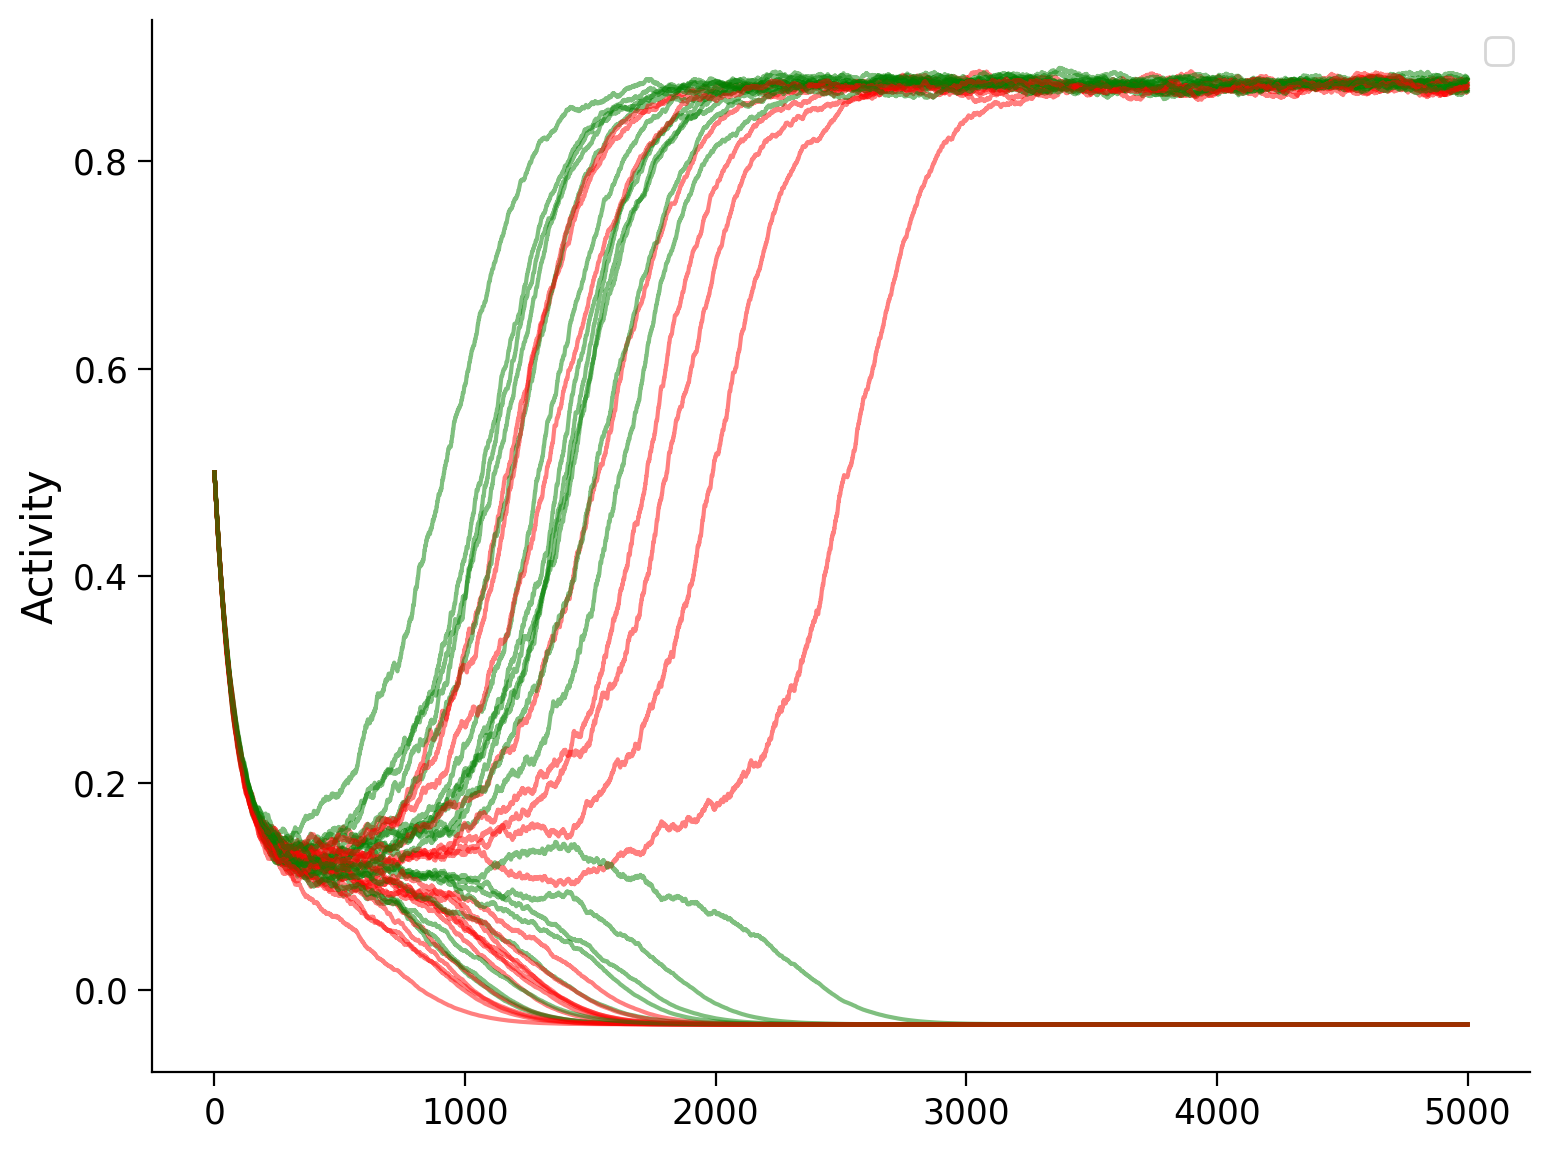

In [ ]:
n_times=20
I_correct=2
I_incorrect=1

rE1_trials, rE2_trials, rI_trials = simulate_task_manytimes(n_times=n_times, p=0.49, I_correct=I_correct,
                                                            I_incorrect=I_incorrect, **pars)

plot_task_simulation(n_times, rE1_trials, rE2_trials, rI_trials)

# **Behavioral metrics**

In [ ]:
#Time-to-decision distribution.
def _find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


def time_to_decision(rE1_trials, rE2_trials, **other_params):

    #Initialise parameters
    dt = pars['dt']

    #initialise populations

    times_dict = {}
    matrices = {'E1':rE1_trials, 'E2':rE2_trials}

    for population in ['E1', 'E2']:

        #choose matrix
        matrix = matrices[population]

        #Initialise decision_times
        decision_times = {'UP':np.zeros(n_times), 'DOWN':np.zeros(n_times)}

        #Loop through use cases
        boundaries = {'UP':0.99, 'DOWN':0.01}
        for decision in ['UP', 'DOWN']:

            boundary = boundaries[decision]

            #define decision-making criterion
            def make_decision(experiment, boundary=boundary):
                decision_index = _find_nearest(experiment, boundary)
                decision=decision_index*dt
                if 0.7>experiment[decision_index]>0.3:
                    decision=float('nan')
                return decision

            #iterate decision-making criterion
            decision_times[decision] = np.apply_along_axis(make_decision, 1, matrix)
            decision_times[decision] = [x for x in decision_times[decision] if str(x) != 'nan']



        #save the results
        times_dict[population]=decision_times


    return times_dict

def plot_time_to_decision_hist(times_dict, n_times, p, bins=50):

    #plot
    fig, ax = plt.subplots(2, 2)
    fig.suptitle(f'p={p}, {n_times} simulations')
    ax[0,0].hist(times_dict['E1']['UP'], bins=bins, color='r')
    ax[0,0].set_title('E1, High')
    ax[0,1].hist(times_dict['E1']['DOWN'], bins=bins, color='r')
    ax[0,1].set_title('E1, Low')
    ax[1,0].hist(times_dict['E2']['UP'], bins=bins, color='g')
    ax[1,0].set_title('E2, High')
    ax[1,1].hist(times_dict['E2']['DOWN'], bins=bins, color='g')
    ax[1,1].set_title('E2, Low')

    for i in [0, 1]:
        for e in [0,1]:
            ax[i, e].set_ylabel('Counts')
            ax[i, e].set_xlabel('Time (ms)')



In [ ]:
#times_dict = time_to_decision(rE1_trials, rE2_trials, **pars)
#plot_time_to_decision_hist(times_dict, n_times, p=p)

In [ ]:
#reaction time curve w reaction time.


def compute_psychometric_values_avg(simulations_per_point = 50, **other_params):
    p_psychometric = [0.9, 0.7, 0.6, 0.55, 0.54, 0.53, 0.52, 0.51, 0.5, 0.49, 0.48, 0.47, 0.46, 0.45, 0.4, 0.3, 0.1]
    data = {}
    for i in p_psychometric:
        p=i
        data[p]={}

        rE1_trials, rE2_trials, rI_trials = simulate_task_manytimes(n_times=simulations_per_point, p=p, I_correct=I_correct,
                                                                I_incorrect=I_incorrect, **pars)
        print(f'Done with {p}')
        times_dict = time_to_decision(rE1_trials, rE2_trials, **pars)
        for population in times_dict:
            data[p][population]={}
            for decision in times_dict[population]:
                data[p][population][decision]={}
                stats = [np.median(times_dict[population][decision]), scipy.stats.iqr(times_dict[population][decision])]
                data[p][population][decision]=stats
                rt_p_data = data
    return rt_p_data


In [ ]:
rt_p_data = compute_psychometric_values_avg(simulations_per_point = 300, **pars)

Done with 0.9


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Done with 0.7
Done with 0.6
Done with 0.55
Done with 0.54
Done with 0.53
Done with 0.52
Done with 0.51
Done with 0.5
Done with 0.49
Done with 0.48
Done with 0.47
Done with 0.46
Done with 0.45
Done with 0.4
Done with 0.3
Done with 0.1


In [ ]:


def plot_rt_psychometric(rt_p_data, population, decision, **other_params):
    pars['T']=T
    data = rt_p_data
    #extreme_values = {'E1':{'UP':T, 'DOWN':0}, 'E2':{'UP':0, 'DOWN':T}}
    #extr = extreme_values[population][decision]
    data_median_plot = np.arange(len(p_psychometric))
    data_iqr_plot = np.arange(len(p_psychometric))
    for i in data_plot:
        if np.isnan(data[p_psychometric[i]][population][decision][0]):
            data_median_plot[i]=T
            data_iqr_plot[i]=0
        else:
            data_median_plot[i]=data[p_psychometric[i]][population][decision][0]
            data_iqr_plot[i]=data[p_psychometric[i]][population][decision][1]/2
    print(data_median_plot)
    plt.scatter(p_psychometric, data_median_plot)
    plt.errorbar(p_psychometric, data_median_plot, yerr=data_iqr_plot)
    plt.ylabel('Reaction time (ms)')
    plt.xlabel('Value of p')
    plt.title(f'Reaction times for {population}, {decision}')

In [ ]:
plot_rt_psychometric(rt_p_data, 'E1', 'DOWN', **pars)

NameError: ignored

# **Short-Term Plasticity**

\begin{align} \tau_{E_1} \frac{dr_{E_1}}{dt} &= -r_{E_1} + F_{E_1}(w_{E_1E_1}s_{E_1} +w_{E_1E_2}s_{E_2} -w_{E_1I}r_I + I^{\text{ext}}_{E_1};a_{E_1},\theta_{E_1}) \\ \tau_{E_2} \frac{dr_{E_2}}{dt} &= -r_{E_2} + F_{E_2}(w_{E_2E_2}s_{E_2} +w_{E_2E_1}s_{E_1} -w_{E_2I}r_I + I^{\text{ext}}_{E_2};a_{E_2},\theta_{E_2})\\ \end{align}

\begin{aligned}
r_I = \frac{\gamma (w_{IE_1}r_{E_1}+w_{IE_2}r_{E_2}+I_I^{ext})}{1+\gamma w_{II}}
\end{aligned}
 \\
  \\

The short term plasticity for excitatory-excitatory connections model is

\begin{align}
\frac{ds_j}{dt} = -\frac{s_j}{\tau_s}+u_jx_jr_j
\end{align}

where $s_j$ refers to the effective rate of the neuron j. That is, the rate that gets through to the other neuron. And the other parameters

\begin{align}
\frac{du_j}{dt}= -\frac{u_j-U}{\tau_u}+U(1-u_j)r_j
\end{align}

\begin{align}
\frac{dx_j}{dt}  = -\frac{x_j-1}{\tau_x}-u_jx_jr_j
\end{align}

U is a constant determining the increment of u produced by an increment in the firing rate.

u is the fraction of the available synaptic resources that is consumed in an action potential

x is the fraction of the total synaptic resources that remains available for use at the presynaptic terminal

s is the effective rate that is transmitted to the postsynaptic partner once STP is taken into account.

The synaptic time scale $\tau_s$ governs the decay of the synaptic activations. The timescale of recovery $\tau_x$ is the main parameter of depression. While the recovery from facilitation is controlled by the timescale $\tau_u$, the parameter $0 < U ≤ 1$ controls the baseline strength of unfacilitated synapses as well as the timescale of their strengthening. For fixed $\tau_u$, we consider smaller values of $U$ to lead to a “stronger” effect of facilitation, and take $U = 1$ as the limit of non-facilitating synapses.

###The function below needs some work still

In [ ]:
# tau_s = 100
# tau_u = 650
# tau_x = 150
# U = 0.5
# x_init = 0
# u_init = 1

#Values as per Seeholzer, Deger, Gerstner (2019)

def simulate_wc_stp(tau_E1, a_E1, theta_E1, tau_E2, a_E2, theta_E2, tau_I, a_I, theta_I,
                wE1E1, wE2E2, wE1E2, wE2E1, wE1I, wE2I, wIE1, wIE2, wII, I_ext_E1, I_ext_E2, I_ext_I,
                rE1_init, rE2_init, rI_init, dt, range_t, gamma, tau_s, tau_u, tau_x, U, x_init, u_init, s_init, **other_pars):
  """
  Simulate the Wilson-Cowan equations
  sE1 = -()
  Args:
    Parameters of the Wilson-Cowan model

  Returns:
    rE1, rE2, rI (arrays) : Activity of excitatory and inhibitory populations
  """

  # Initialize activity arrays
  Lt = range_t.size
  rE1 = np.append(rE1_init, np.zeros(Lt - 1))
  rE2 = np.append(rE2_init, np.zeros(Lt - 1))
  rI = np.append(rI_init, np.zeros(Lt - 1))
  I_ext_E1 = 100 * np.ones(Lt)
  I_ext_E2 = I_ext_E2 * np.ones(Lt)
  I_ext_I = I_ext_I * np.ones(Lt)

  #Initialize STP arrays
  sE1 = np.append(rE1_init, np.zeros(Lt - 1))
  sE2 = np.append(rE2_init, np.zeros(Lt - 1))
  xE1 = np.append(x_init, np.zeros(Lt - 1))
  xE2 = np.append(x_init, np.zeros(Lt - 1))
  uE1 = np.append(u_init, np.zeros(Lt - 1))
  uE2 = np.append(u_init, np.zeros(Lt - 1))

  # Simulate the Wilson-Cowan equations
  for k in range(Lt - 1):

    #update the state of the I population
    rI[k] = (gamma*(wIE1*rE1[k] + wIE2*rE2[k] + I_ext_I[k]))/(1+gamma*wII)

    #calculate the derivative of u
    duE1 = dt * (-((uE1[k]-U)/tau_u) + U*(1-uE1[k])*rE1[k])
    duE2 = dt * (-((uE2[k]-U)/tau_u) + U*(1-uE2[k])*rE2[k])

    #calculate the derivative of x
    dxE1 = dt * (-((xE1[k]-1)/tau_x) + (uE1[k])*xE1[k]*rE1[k])
    dxE2 = dt * (-((xE2[k]-1)/tau_x) + (uE2[k])*xE2[k]*rE2[k])

    #calculate the derivative of s
    dsE1 = dt * (-((sE1[k])/tau_s) + (uE1[k])*xE1[k]*rE1[k])
    dsE2 = dt * (-((sE2[k])/tau_s) + (uE2[k])*xE2[k]*rE2[k])

    # Calculate the derivative of the E1 population
    drE1 = dt / tau_E1 * (-rE1[k] + F(wE1E1 * sE1[k] + wE1E2 * sE2[k] - wE1I * rI[k] + I_ext_E1[k],
                                   a_E1, theta_E1))

    # Calculate the derivative of the E2 population
    drE2 = dt / tau_E2 * (-rE2[k] + F(wE2E2 * sE2[k] + wE2E1 * sE1[k] - wE2I * rI[k] + I_ext_E2[k],
                                   a_E2, theta_E2))

    ### Integration ###

    # Update firing rates using Euler's method
    rE1[k + 1] = rE1[k] + drE1
    rE2[k + 1] = rE2[k] + drE2

    #update plasticity parameters using Euler's method
    uE1[k + 1] = uE1[k] + duE1
    uE2[k + 1] = uE2[k] + duE2

    xE1[k + 1] = xE1[k] + dxE1
    xE2[k + 1] = xE2[k] + dxE2

    sE1[k + 1] = sE1[k] + dsE1
    sE2[k + 1] = sE2[k] + dsE2


  return sE1, sE2, rI, uE1, uE2, xE1, xE2, rE1, rE2



# # Simulate a trajectory
@widgets.interact(
    rE1_init=widgets.FloatSlider(0.5, min=0.0, max=0.95, step=.01),
    rE2_init=widgets.FloatSlider(0.5, min=0.0, max=0.95, step=.01),
    U=widgets.FloatSlider(0.5, min=0.0, max=1, step=0.1),
    tau_u=widgets.FloatSlider(650, min=0.0, max=1000, step=25),
    tau_x=widgets.FloatSlider(150, min=0.0, max=1000, step=25),
    tau_s=widgets.FloatSlider(100, min=0.0, max=1000, step=25)
)

def plot_EI_diffinitial1(rE1_init=0.0, rE2_init=0.0, U=0.0, tau_u=0, tau_x=0, tau_s=0):

  pars = default_pars(rE1_init=rE1_init, rE2_init=rE2_init, U=U, tau_u=tau_u, tau_x=tau_x, tau_s=tau_s)
  sE1,sE2,rI,uE1,uE2,xE1,xE2,rE1, rE2 = simulate_wc_stp(**pars)

  plt.figure()
  plt.plot(pars['range_t'], rE1, 'r', label='E1 population (with STP)' )
  plt.plot(pars['range_t'], rE2, 'g', label='E2 population (with STP)')
  plt.xlabel('t (ms)')
  plt.ylabel('Activity')
  plt.legend(loc='best')
  plt.show()

*italicized text*## Nullclines with STP

Let's cheat. We can solve the nullclines for $s_{j}$, and we can translate the values of s to values of r if we assume $ds_j[k] = ds_k[k+1]$, which we can do safely by reducing the timestep $dt$ to half of its value.

From the equation for $ds_j$:

\begin{align}
r_j = (\frac{ds_j}{dt}+\frac{s_j}{\tau_s})\frac{1}{u_jx_j}
\end{align}

Need to understand models and initialization values

In [ ]:
def euler_nullcline_E1_STP(tau_E1, a_E1, theta_E1, tau_E2, a_E2, theta_E2, tau_I, a_I, theta_I,
                wE1E1, wE2E2, wE1E2, wE2E1, wE1I, wE2I, wIE1, wIE2, wII, I_ext_E1, I_ext_E2, I_ext_I,
                rE1_init, rE2_init, rI_init, dt, range_t, gamma, tau_s, tau_u, tau_x, U, s_init, x_init, u_init, **other_pars):

  """
  What if we calculate the nullclines as an euler integration? Just because it would be a pain to make everything into two neat equations.

  1. We
  """

  # Initialize activity arrays
  Lt = range_t.size
  rE1 = np.append(rE1_init, np.zeros(Lt - 1))
  rE2 = np.append(rE2_init, np.zeros(Lt - 1))

  #Initialize effective activity arrays
  #Initialize STP arrays
  sE1 = np.append(s_init, np.zeros(Lt - 1))
  sE2 = np.append(s_init, np.zeros(Lt - 1))
  xE1 = np.append(x_init, np.zeros(Lt - 1))
  xE2 = np.append(x_init, np.zeros(Lt - 1))
  uE1 = np.append(u_init, np.zeros(Lt - 1))
  uE2 = np.append(u_init, np.zeros(Lt - 1))

  #calculate first value of ds

  dsE1 = dt * (-((sE1[0])/tau_s) + (uE1[0])*xE1[0]*rE1[0])
  dsE2 = dt * (-((sE2[0])/tau_s) + (uE2[0])*xE2[0]*rE2[0])

  #Calculate nullcline for sE2. initialize sE1.

  sE1 = np.linspace(-0.2, 0.96, 1000)
  sE2 = (1/(wE1E2 - ((gamma * wE1I * wIE2)/(1+gamma*wII))))*(F_inv(sE1, a_E1, theta_E1)-wE1E1*sE1 + (gamma*wE1I/(1+gamma*wII))*(wIE1*sE1 + I_ext_I) - I_ext_E1)


  # Integrate the STP model to get r from s, assuming ds[k]==ds[k+1]
  for k in range(Lt - 1):

    #calculate r
    rE1[k] = ((dsE1/dt)+(sE1[k]/tau_s)) * (uE1[k]*xE1[k])**-1    rE2[k] = ((dsE2/dt)+(sE2[k]/tau_s)) * (uE2[k]*xE2[k])**-1

    #calculate the derivative of u
    duE1 = dt * (-((uE1[k]-U)/tau_u) + U*(1-uE1[k])*rE1[k])
    duE2 = dt * (-((uE2[k]-U)/tau_u) + U*(1-uE2[k])*rE2[k])

    #calculate the derivative of x
    dxE1 = dt * (-((xE1[k]-1)/tau_x) + (uE1[k])*xE1[k]*rE1[k])
    dxE2 = dt * (-((xE2[k]-1)/tau_x) + (uE2[k]*xE2[k]*rE2[k]))
    dsE1 = dt * (-((sE1[k])/tau_s) + (uE1[k])*xE1[k]*rE1[k])
    dsE2 = dt * (-((sE2[k])/tau_s) + (uE2[k])*xE2[k]*rE2[k])

    #update plasticity parameters using Euler's method
    uE1[k + 1] = uE1[k] + duE1
    uE2[k + 1] = uE2[k] + duE2

    xE1[k + 1] = xE1[k] + dxE1
    xE2[k + 1] = xE2[k] + dxE2

    #We don't update r bc it's already defined, we're going along the nullcline

    return rE1, rE2

def euler_nullcline_E2_STP(tau_E1, a_E1, theta_E1, tau_E2, a_E2, theta_E2, tau_I, a_I, theta_I,
                wE1E1, wE2E2, wE1E2, wE2E1, wE1I, wE2I, wIE1, wIE2, wII, I_ext_E1, I_ext_E2, I_ext_I,
                rE1_init, rE2_init, rI_init, dt, range_t, gamma, tau_s, tau_u, tau_x, U, **other_pars):
  print('in progress')

# **Messy part which doesn't work :'( task with STP**

In [ ]:
def simulate_task_wc_stp(I_task_E1, I_task_E2, tau_E1, a_E1, theta_E1, tau_E2, a_E2, theta_E2, tau_I, a_I, theta_I,
                wE1E1, wE2E2, wE1E2, wE2E1, wE1I, wE2I, wIE1, wIE2, wII, I_ext_E1, I_ext_E2, I_ext_I,
                rE1_init, rE2_init, rI_init, dt, range_t, gamma, tau_s, tau_u, tau_x, U, x_init, u_init, s_init, **other_pars):
  """
  Simulate the Wilson-Cowan equations
  Args:
    Parameters of the Wilson-Cowan model

  Returns:
    rE1, rE2, rI (arrays) : Activity of excitatory and inhibitory populations
  """

# Initialize activity arrays
  Lt = range_t.size
  rE1 = np.append(0.5, np.zeros(Lt - 1))
  rE2 = np.append(0.5, np.zeros(Lt - 1))
  rI = np.append(rI_init, np.zeros(Lt - 1))
  I_ext_E1 = I_task_E1
  I_ext_E2 = I_task_E2
  I_ext_I = I_ext_I * np.ones(Lt)
  #playing with some weights here
  wE1I, wE2I = 120, 120

  #Initialize STP arrays
  sE1 = np.append(s_init, np.zeros(Lt - 1))
  sE2 = np.append(s_init, np.zeros(Lt - 1))
  sI1 = np.append(s_init, np.zeros(Lt - 1))
  sI2 = np.append(s_init, np.zeros(Lt - 1))
  xE1 = np.append(x_init, np.zeros(Lt - 1))
  xE2 = np.append(x_init, np.zeros(Lt - 1))
  xI1 = np.append(x_init, np.zeros(Lt - 1))
  xI2 = np.append(x_init, np.zeros(Lt - 1))
  uE1 = np.append(u_init, np.zeros(Lt - 1))
  uE2 = np.append(u_init, np.zeros(Lt - 1))
  uI1 = np.append(u_init, np.zeros(Lt - 1))
  uI2 = np.append(u_init, np.zeros(Lt - 1))

  # Simulate the Wilson-Cowan equations
  for k in range(Lt - 1):

    #calculate the derivative of u
    duE1 = dt * (-((uE1[k]-U)/tau_u) + U*(1-uE1[k])*rE1[k])
    duE2 = dt * (-((uE2[k]-U)/tau_u) + U*(1-uE2[k])*rE2[k])
    duI1 = dt * (-((uI1[k]-U)/tau_u) + U*(1-uI1[k])*rI[k])
    duI2 = dt * (-((uI2[k]-U)/tau_u) + U*(1-uI2[k])*rI[k])

    #calculate the derivative of x
    dxE1 = dt * (-((xE1[k]-1)/tau_x) - (uE1[k])*xE1[k]*rE1[k])
    dxE2 = dt * (-((xE2[k]-1)/tau_x) - (uE2[k])*xE2[k]*rE2[k])
    dxI1 = dt * (-((xI1[k]-1)/tau_x) - (uI1[k])*xI1[k]*rI[k])
    dxI2 = dt * (-((xI2[k]-1)/tau_x) - (uI2[k])*xI2[k]*rI[k])

    #calculate the derivative of s
    dsE1 = dt * (-((sE1[k])/tau_s) + (uE1[k])*xE1[k]*rE1[k])
    dsE2 = dt * (-((sE2[k])/tau_s) + (uE2[k])*xE2[k]*rE2[k])
    dsI1 = dt * (-((sI1[k])/tau_s) + (uI1[k])*xI1[k]*rI[k])
    dsI2 = dt * (-((sI2[k])/tau_s) + (uI2[k])*xI2[k]*rI[k])

    # Calculate the derivative of the I population
    drI = dt / tau_I * (-rI[k] + F(wIE1 * sE1[k] + wIE2 * sE2[k] - wII * rI[k] + I_ext_I[k], a_I, theta_I))

    # Calculate the derivative of the E1 population
    drE1 = dt / tau_E1 * (-rE1[k] + F(wE1E1 * sE1[k] + wE1E2 * rE2[k] - wE1I * sI1[k] + I_ext_E1[k],
                                   a_E1, theta_E1))

    # Calculate the derivative of the E2 population
    drE2 = dt / tau_E2 * (-rE2[k] + F(wE2E2 * sE2[k] + wE2E1 * rE1[k] - wE2I * sI2[k] + I_ext_E2[k],
                                   a_E2, theta_E2))

    ### Integration ###
    # Update firing rates using Euler's method
    rE1[k + 1] = rE1[k] + drE1
    rE2[k + 1] = rE2[k] + drE2
    rI[k + 1] = rI[k] + drI

    #update plasticity parameters using Euler's method
    uE1[k + 1] = uE1[k] + duE1
    uE2[k + 1] = uE2[k] + duE2
    uI1[k + 1] = uI1[k] + duI1
    uI2[k + 1] = uI2[k] + duI2

    xE1[k + 1] = xE1[k] + dxE1
    xE2[k + 1] = xE2[k] + dxE2
    xI1[k + 1] = xI1[k] + dxI1
    xI2[k + 1] = xI2[k] + dxI2

    sE1[k + 1] = sE1[k] + dsE1
    sE2[k + 1] = sE2[k] + dsE2
    sI1[k + 1] = sI1[k] + dsI1
    sI2[k + 1] = sI2[k] + dsI2

  return rE1, rE2, rI

def simulate_task_manytimes_stp(n_times, p, I_correct, I_incorrect, **other_pars):
  """
  Iterate simulate_task_wc many times and save the results as a matrix
  """
  #get values of params
  tau_E1, a_E1, theta_E1 = pars['tau_E1'], pars['a_E1'], pars['theta_E1']
  tau_E2, a_E2, theta_E2 = pars['tau_E2'], pars['a_E2'], pars['theta_E2']
  wE1E1, wE1E2 = pars['wE1E1'], pars['wE1E2']
  wE2E1, wE2E2 = pars['wE2E1'], pars['wE2E2']
  I_ext_E1, I_ext_E2, I_ext_I = pars['I_ext_E1'], pars['I_ext_E2'], pars['I_ext_I']
  gamma = pars['gamma']
  wIE1, wIE2, wII, wE1I, wE2I = pars['wIE1'],pars['wIE2'],pars['wII'], pars['wE1I'], pars['wE2I']
  range_t = pars['range_t']
  #get length of time
  Lt = range_t.size
  #Initialize a matrix
  rE1_trials=np.zeros((n_times, Lt))
  rE2_trials=np.zeros((n_times, Lt))
  rI_trials=np.zeros((n_times, Lt))

  #Iterate
  for i in range(n_times):
      #Simulate a noisy input
      I_task_E1, I_task_E2 = get_task_input(p, I_correct, I_incorrect, **pars)
      #Simulate a trajectory
      rE1, rE2, rI = simulate_task_wc_stp(I_task_E1, I_task_E2, **other_pars)
      #save values
      rE1_trials[i,:]=rE1
      rE2_trials[i,:]=rE2
      rI_trials[i,:]=rI
  return(rE1_trials, rE2_trials, rI_trials)

def plot_task_simulation_stp(n_times, rE1_trials, rE2_trials, rI_trials):
  """
  Plot the results of simulate_task_manytimes
  """
  plt.figure()
  for i in range(n_times):
      plt.plot(rE1_trials[i,:], 'r', alpha=0.5)
      plt.plot(rE2_trials[i,:], 'g', alpha=0.5)
      # plt.plot(rI_trials[i,:], 'b', alpha=0.5)
  plt.ylabel('Activity')
  # plt.legend()
  plt.show()



n_times=20
I_correct=5
I_incorrect=1

rE1_trials, rE2_trials, rI_trials = simulate_task_manytimes_stp(n_times=n_times, p=0.49, I_correct=I_correct,
                                                            I_incorrect=I_incorrect, **pars)


plot_task_simulation_stp(n_times, rE1_trials, rE2_trials, rI_trials)

# Hopefully better!

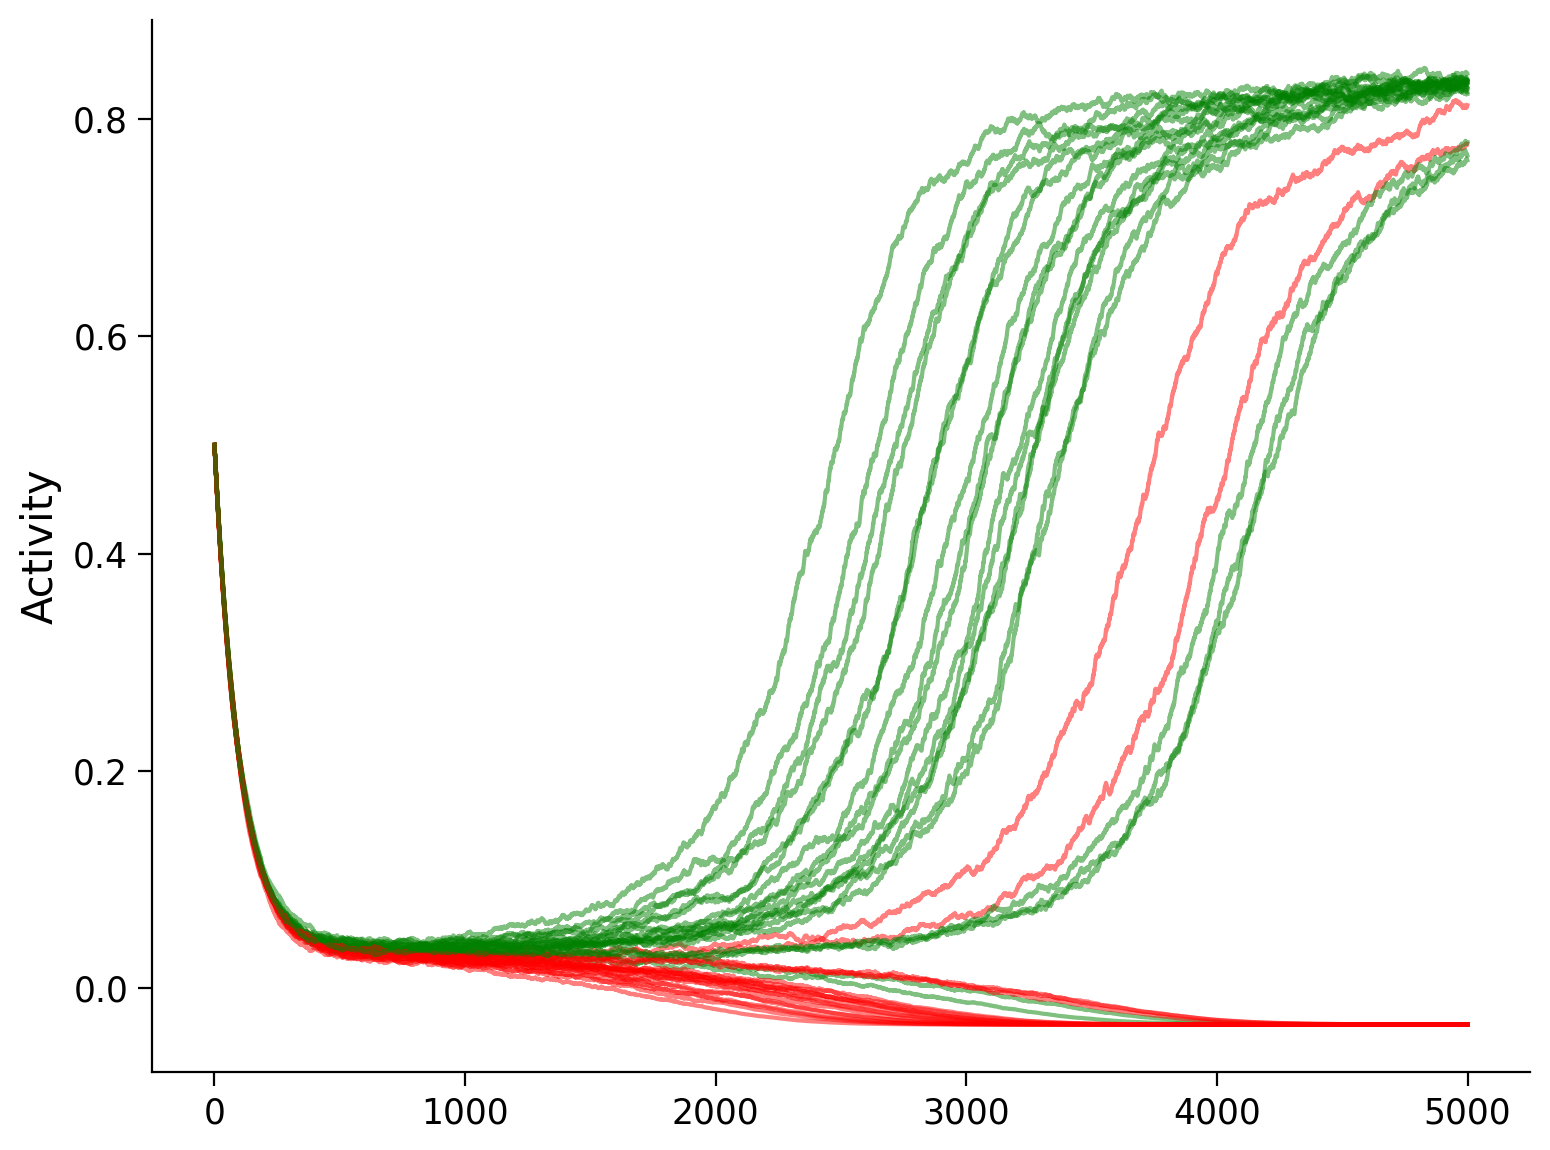

In [ ]:
def simulate_task_wc_stp(I_task_E1, I_task_E2, tau_E1, a_E1, theta_E1, tau_E2, a_E2, theta_E2, tau_I, a_I, theta_I,
                wE1E1, wE2E2, wE1E2, wE2E1, wE1I, wE2I, wIE1, wIE2, wII, I_ext_E1, I_ext_E2, I_ext_I,
                rE1_init, rE2_init, rI_init, dt, range_t, gamma, tau_s, tau_u, tau_x, U, x_init, u_init, s_init, **other_pars):
  """
  Simulate the Wilson-Cowan equations
  Args:
    Parameters of the Wilson-Cowan model

  Returns:
    rE1, rE2, rI (arrays) : Activity of excitatory and inhibitory populations
  """

# Initialize activity arrays
  Lt = range_t.size
  rE1 = np.append(0.5, np.zeros(Lt - 1))
  rE2 = np.append(0.5, np.zeros(Lt - 1))
  rI = np.append(rI_init, np.zeros(Lt - 1))
  I_ext_E1 = I_task_E1
  I_ext_E2 = I_task_E2
  I_ext_I = 0 * np.ones(Lt)
  #playing with some weights here
  # wE1I, wE2I = 7, 7
  # wE1E1, wE2E2 = 4, 4
  # wIE1, wIE2 = 5, 5
  #Initialize STP arrays
  sE1 = np.append(s_init, np.zeros(Lt - 1))
  sE2 = np.append(s_init, np.zeros(Lt - 1))
  xE1 = np.append(x_init, np.zeros(Lt - 1))
  xE2 = np.append(x_init, np.zeros(Lt - 1))
  uE1 = np.append(u_init, np.zeros(Lt - 1))
  uE2 = np.append(u_init, np.zeros(Lt - 1))

  # Simulate the Wilson-Cowan equations
  for k in range(Lt - 1):

    rI[k] = (gamma*(wIE1*sE1[k] + wIE2*sE2[k] + I_ext_I[k]))/(1+gamma*wII)
    #calculate the derivative of u
    duE1 = dt * (-((uE1[k]-U)/tau_u) + U*(1-uE1[k])*rE1[k])
    duE2 = dt * (-((uE2[k]-U)/tau_u) + U*(1-uE2[k])*rE2[k])

    #calculate the derivative of x
    dxE1 = dt * (-((xE1[k]-1)/tau_x) - (uE1[k])*xE1[k]*rE1[k])
    dxE2 = dt * (-((xE2[k]-1)/tau_x) - (uE2[k])*xE2[k]*rE2[k])

    #calculate the derivative of s
    dsE1 = dt * (-((sE1[k])/tau_s) + (uE1[k])*xE1[k]*rE1[k])
    dsE2 = dt * (-((sE2[k])/tau_s) + (uE2[k])*xE2[k]*rE2[k])

    # Calculate the derivative of the E1 population
    drE1 = dt / tau_E1 * (-rE1[k] + F(wE1E1 * sE1[k] + wE1E2 * sE2[k] - wE1I * rI[k] + I_ext_E1[k],
                                   a_E1, theta_E1))

    # Calculate the derivative of the E2 population
    drE2 = dt / tau_E2 * (-rE2[k] + F(wE2E2 * sE2[k] + wE2E1 * sE1[k] - wE2I * rI[k] + I_ext_E2[k],
                                   a_E2, theta_E2))

    ### Integration ###

    # Update firing rates using Euler's method
    rE1[k + 1] = rE1[k] + drE1
    rE2[k + 1] = rE2[k] + drE2

    # rI[k + 1] = rI[k] + drI

    #update plasticity parameters using Euler's method
    uE1[k + 1] = uE1[k] + duE1
    uE2[k + 1] = uE2[k] + duE2

    xE1[k + 1] = xE1[k] + dxE1
    xE2[k + 1] = xE2[k] + dxE2

    sE1[k + 1] = sE1[k] + dsE1
    sE2[k + 1] = sE2[k] + dsE2

  return rE1, rE2, rI

def simulate_task_manytimes_stp(n_times, p, I_correct, I_incorrect, **other_pars):
  """
  Iterate simulate_task_wc many times and save the results as a matrix
  """
  #get values of params
  tau_E1, a_E1, theta_E1 = pars['tau_E1'], pars['a_E1'], pars['theta_E1']
  tau_E2, a_E2, theta_E2 = pars['tau_E2'], pars['a_E2'], pars['theta_E2']
  wE1E1, wE1E2 = pars['wE1E1'], pars['wE1E2']
  wE2E1, wE2E2 = pars['wE2E1'], pars['wE2E2']
  I_ext_E1, I_ext_E2, I_ext_I = pars['I_ext_E1'], pars['I_ext_E2'], pars['I_ext_I']
  gamma = pars['gamma']
  wIE1, wIE2, wII, wE1I, wE2I = pars['wIE1'],pars['wIE2'],pars['wII'], pars['wE1I'], pars['wE2I']
  range_t = pars['range_t']


  #get length of time
  Lt = range_t.size
  #Initialize a matrix
  rE1_trials=np.zeros((n_times, Lt))
  rE2_trials=np.zeros((n_times, Lt))
  rI_trials=np.zeros((n_times, Lt))

  #Iterate
  for i in range(n_times):
      #Simulate a noisy input
      I_task_E1, I_task_E2 = get_task_input(p, I_correct, I_incorrect, **pars)
      #Simulate a trajectory
      rE1, rE2, rI = simulate_task_wc_stp(I_task_E1, I_task_E2, **other_pars)
      #save values
      rE1_trials[i,:]=rE1
      rE2_trials[i,:]=rE2
      rI_trials[i,:]=rI
  return(rE1_trials, rE2_trials, rI_trials)

def plot_task_simulation_stp(n_times, rE1_trials, rE2_trials, rI_trials):
  """
  Plot the results of simulate_task_manytimes
  """
  plt.figure()
  for i in range(n_times):
      plt.plot(rE1_trials[i,:], 'r', alpha=0.5)
      plt.plot(rE2_trials[i,:], 'g', alpha=0.5)
      # plt.plot(rI_trials[i,:], 'b', alpha=0.5)
  plt.ylabel('Activity')
  plt.show()

n_times=20
I_correct=2
I_incorrect=1

rE1_trials, rE2_trials, rI_trials = simulate_task_manytimes_stp(n_times=n_times, p=0.49, I_correct=I_correct,
                                                            I_incorrect=I_incorrect, **pars)

plot_task_simulation_stp(n_times, rE1_trials, rE2_trials, rI_trials)

# Experiments!

In [ ]:
def simulate_task_manytimes_experiment(n_times, p, I_correct, I_incorrect, **other_pars):
  """
  Iterate simulate_task_wc many times and save the results as a matrix
  """
  #get values of params
  tau_E1, a_E1, theta_E1 = pars['tau_E1'], pars['a_E1'], pars['theta_E1']
  tau_E2, a_E2, theta_E2 = pars['tau_E2'], pars['a_E2'], pars['theta_E2']
  wE1E1, wE1E2 = pars['wE1E1'], pars['wE1E2']
  wE2E1, wE2E2 = pars['wE2E1'], pars['wE2E2']
  I_ext_E1, I_ext_E2, I_ext_I = pars['I_ext_E1'], pars['I_ext_E2'], pars['I_ext_I']
  gamma = pars['gamma']
  wIE1, wIE2, wII, wE1I, wE2I = pars['wIE1'],pars['wIE2'],pars['wII'], pars['wE1I'], pars['wE2I']
  range_t = pars['range_t']


  #get length of time
  Lt = range_t.size
  #Initialize a matrix
  rE1_trials_stp=np.zeros((n_times, Lt))
  rE2_trials_stp=np.zeros((n_times, Lt))
  rI_trials_stp=np.zeros((n_times, Lt))
  rE1_trials=np.zeros((n_times, Lt))
  rE2_trials=np.zeros((n_times, Lt))
  rI_trials=np.zeros((n_times, Lt))

  #Iterate
  for i in range(n_times):
      #Simulate a noisy input
      I_task_E1, I_task_E2 = get_task_input(p, I_correct, I_incorrect, **pars)
      #Simulate a trajectory
      rE1, rE2, rI = simulate_task_wc_stp(I_task_E1, I_task_E2, **pars)
      rrE1, rrE2, rrI = simulate_task_wc(I_task_E1, I_task_E2, **pars)
      #save values
      rE1_trials_stp[i,:]=rE1
      rE2_trials_stp[i,:]=rE2
      rI_trials_stp[i,:]=rI
      rE1_trials[i,:]=rrE1
      rE2_trials[i,:]=rrE2
      rI_trials[i,:]=rrI
  return(rE1_trials_stp, rE2_trials_stp, rI_trials_stp, rE1_trials, rE2_trials, rI_trials)

In [ ]:
def plot_task_simulation_stp(n_times, rE1_trials_stp, rE2_trials_stp, rI_trials_stp, rE1_trials, rE2_trials, rI_trials):
  """
  Plot the results of simulate_task_manytimes
  """
  plt.figure()
  for i in range(n_times):
      plt.subplot(2, 1, 1)
      plt.plot(rE1_trials_stp[i,:], '#1AFF1A', alpha=0.5)
      plt.plot(rE2_trials_stp[i,:], '#4B0092', alpha=0.5)
      plt.ylabel('Activity')

      plt.subplot(2, 1, 2)
      plt.plot(rE1_trials[i,:], 'm', alpha=0.5)
      plt.plot(rE2_trials[i,:], 'c', alpha=0.5)
      plt.ylabel('Activity')

  plt.subplot(2, 1, 1)
  plt.plot(rE1_trials_stp[0,:], '#1AFF1A', label='E1 with STP')
  plt.plot(rE2_trials_stp[0,:], '#4B0092', label='E2 with STP')
  plt.legend()
  plt.subplot(2, 1, 2)
  plt.plot(rE1_trials[0,:], 'm', label='E1 without STP')
  plt.plot(rE2_trials[0,:], 'c', label='E2 without STP')
  plt.legend()
  plt.show()

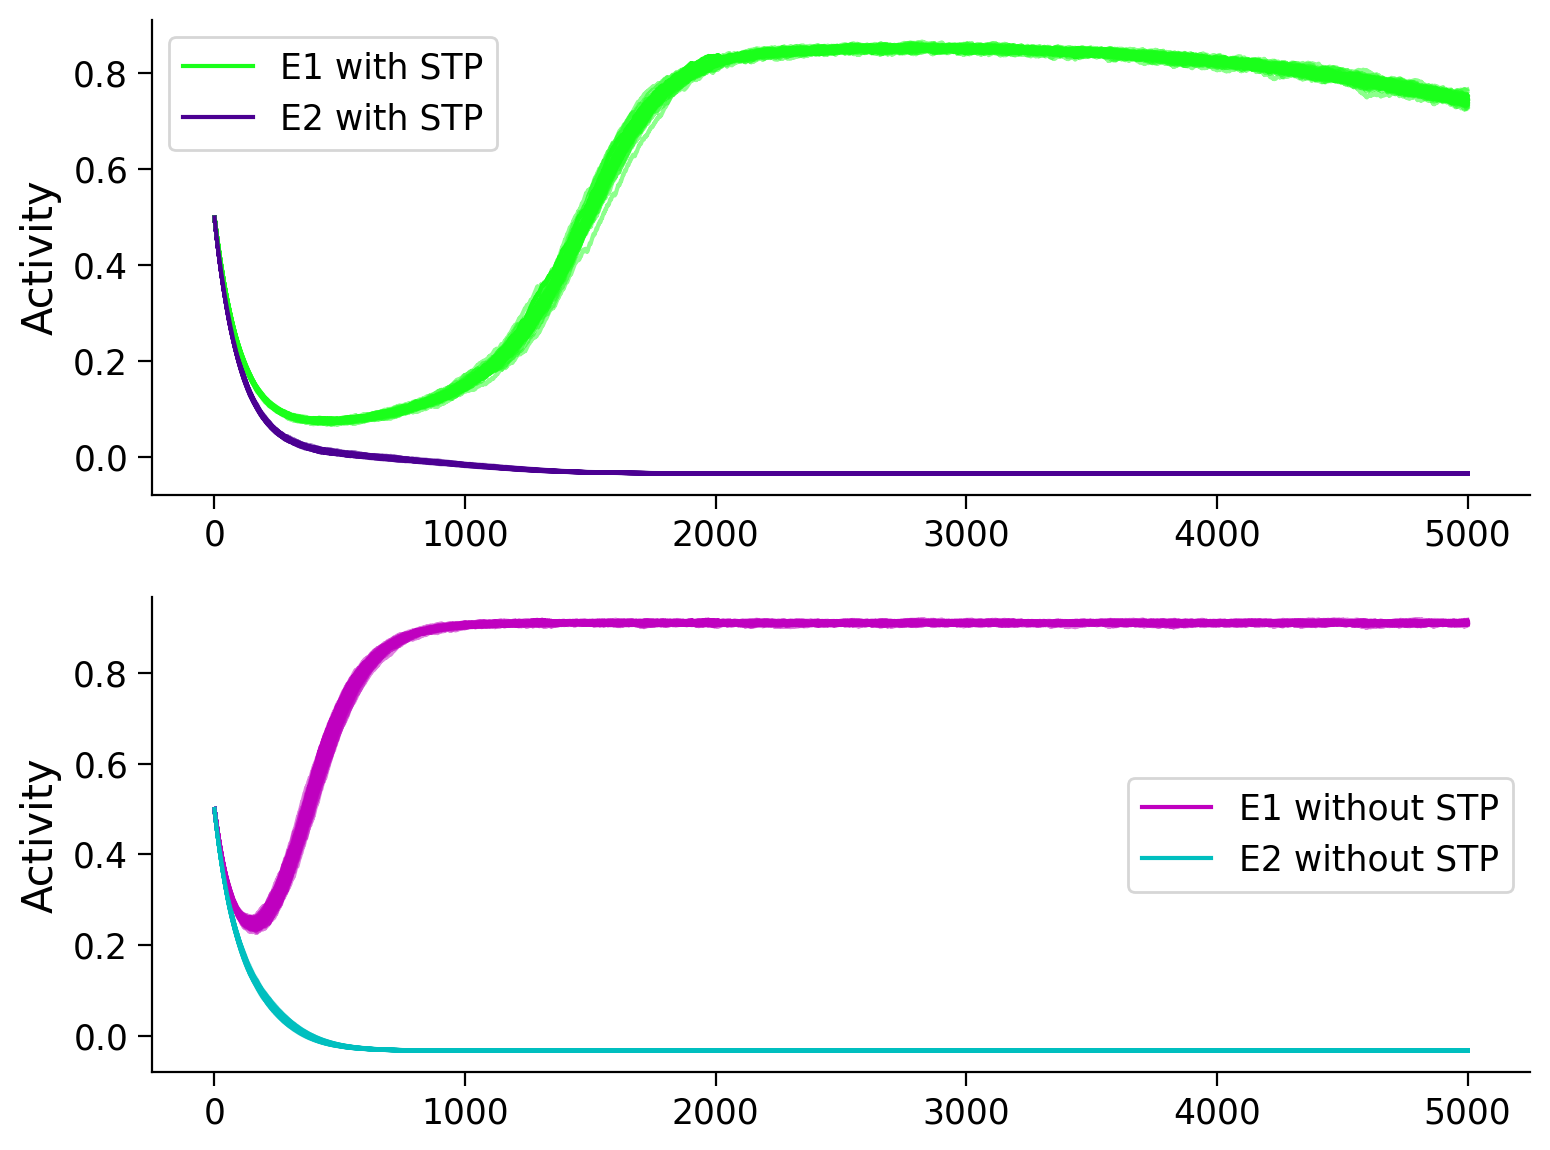

In [ ]:
n_times=50
p=0.8
rE1_trials_stp, rE2_trials_stp, rI_trials_stp, rE1_trials, rE2_trials, rI_trials = simulate_task_manytimes_experiment(n_times, p, I_correct=2, I_incorrect=1, **pars)
plot_task_simulation_stp(n_times, rE1_trials_stp, rE2_trials_stp, rI_trials_stp, rE1_trials, rE2_trials, rI_trials)

# Experiment metrics

In [ ]:
#Time-to-decision distribution.
def _find_threshold_UP(array, value):
    array = np.array(array)
    converg = np.argwhere(array>value)
    if len(converg)==0:
        idx=float('nan')
    else:
        idx = converg[0]
    return idx

def _find_threshold_DOWN(array, value):
    array = np.array(array)
    converg = np.argwhere(array<value)
    if len(converg)==0:
        idx=float('nan')
    else:
        idx = converg[0]
    return idx

threshold_dict = {'UP':_find_threshold_UP, 'DOWN':_find_threshold_DOWN}

def time_to_decision(rE1_trials, rE2_trials, **other_params):

    #Initialise parameters
    dt = pars['dt']

    #initialise populations

    times_dict = {}
    matrices = {'E1':rE1_trials, 'E2':rE2_trials}

    for population in ['E1', 'E2']:

        #choose matrix
        matrix = matrices[population]

        #Initialise decision_times
        decision_times = {'UP':np.zeros(n_times), 'DOWN':np.zeros(n_times)}

        #Loop through use cases
        boundaries = {'UP':0.8, 'DOWN':0.01}
        for decision in ['UP', 'DOWN']:

            boundary = boundaries[decision]

            #define decision-making criterion
            def make_decision(experiment, boundary=boundary, decision=decision):
                decision_index = threshold_dict[decision](experiment, boundary)
                decision=decision_index*dt
                return decision

            #iterate decision-making criterion
            decision_times[decision] = np.apply_along_axis(make_decision, 1, matrix)
            decision_times[decision] = decision_times[decision][~np.isnan(decision_times[decision])]


        #save the results
        times_dict[population]=decision_times


    return times_dict

def plot_time_to_decision_hist_exp(times_dict, times_dict_stp, n_times, p, bins=50):

    #plot
    fig, ax = plt.subplots(2, 2)
    fig.suptitle(f'p={p}, {n_times} simulations')
ax[0,0].hist(times_dict['E1']['UP'], bins=bins, color='m', alpha=0.5)
    ax[0,0].hist(times_dict['E1']['UP'], bins=bins, color='m', alpha=0.5)
    ax[0,0].hist(times_dict_stp['E1']['UP'], bins=bins, color='#1AFF1A', alpha=0.5)
    ax[0,0].set_title('E1, High')
    ax[0,1].hist(times_dict['E1']['DOWN'], bins=bins, color='m', alpha=0.5)
    ax[0,1].hist(times_dict_stp['E1']['DOWN'], bins=bins, color='#1AFF1A', alpha=0.5)
    ax[0,1].set_title('E1, Low')
    ax[1,0].hist(times_dict['E2']['UP'], bins=bins, color='c', alpha=0.5)
    ax[1,0].hist(times_dict_stp['E2']['UP'], bins=bins, color='#4B0092', alpha=0.5)
    ax[1,0].set_title('E2, High')
    ax[1,1].hist(times_dict['E2']['DOWN'], bins=bins, color='c', alpha=0.5)
    ax[1,1].hist(times_dict_stp['E2']['DOWN'], bins=bins, color='#4B0092', alpha=0.5)
    ax[1,1].set_title('E2, Low')

    for i in [0, 1]:
        for e in [0,1]:
            ax[i, e].set_ylabel('Counts')
            ax[i, e].set_xlabel('Time (ms)')




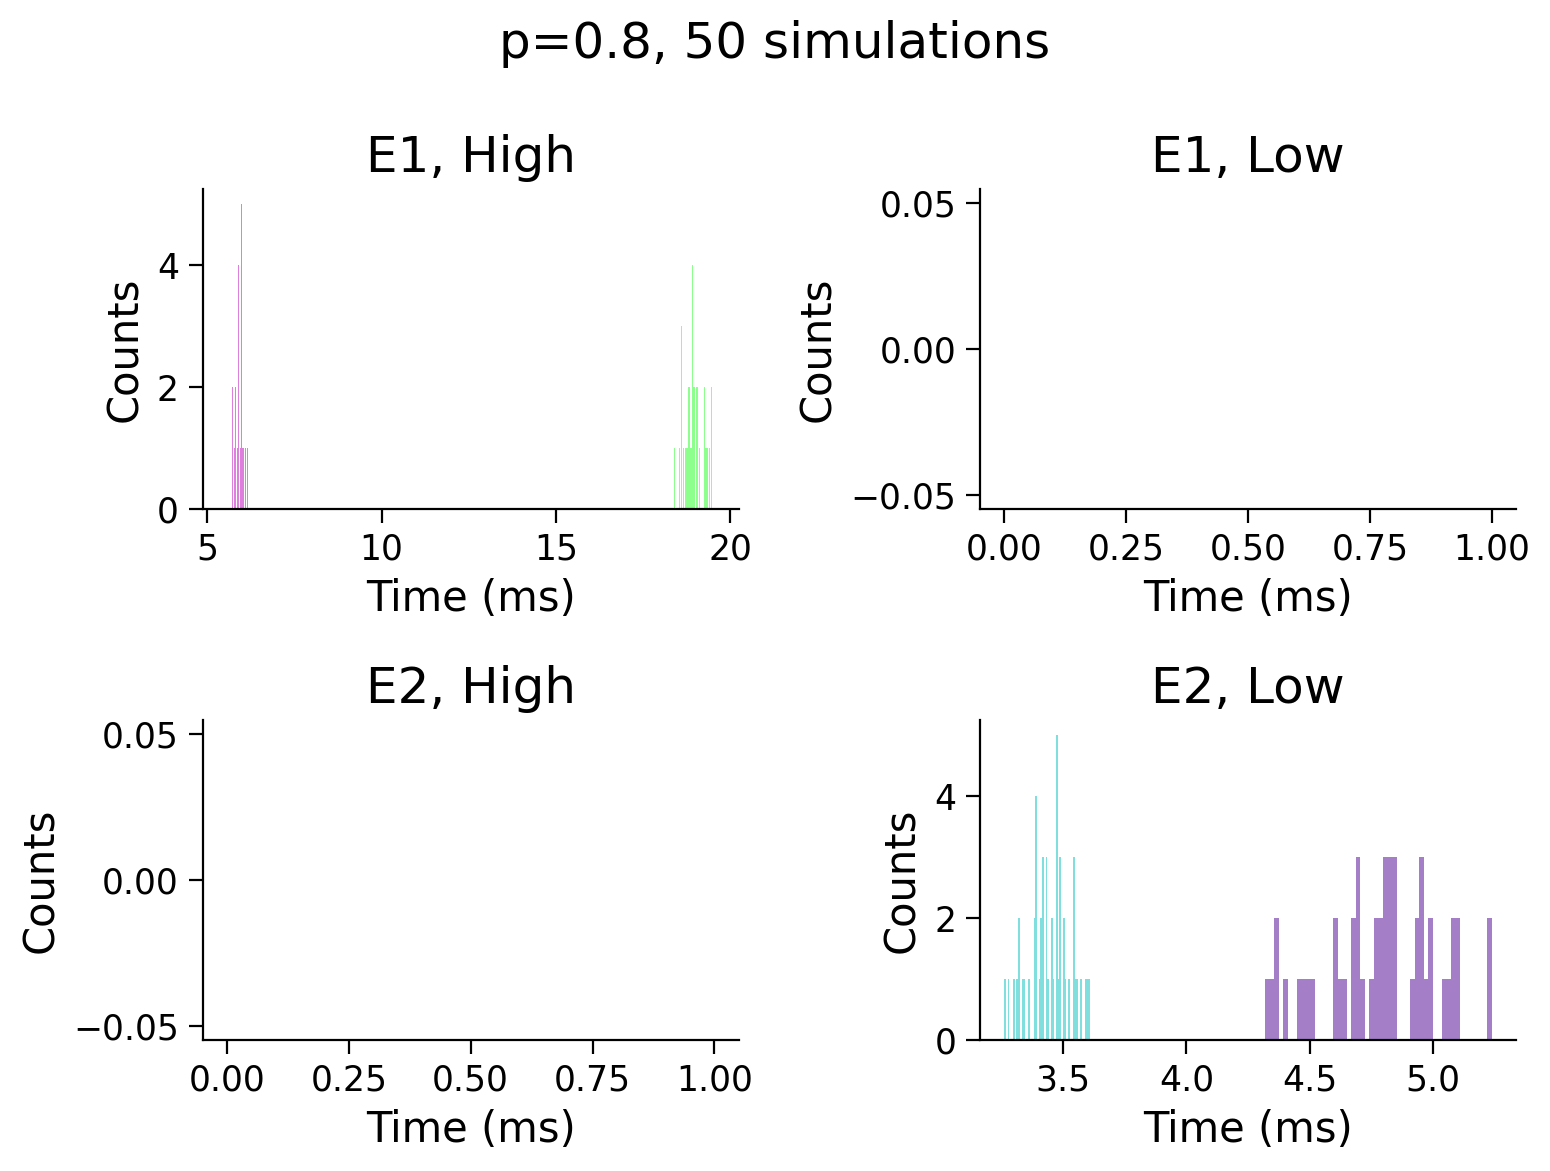

In [ ]:
times_dict = time_to_decision(rE1_trials, rE2_trials, **pars)
times_dict_stp = time_to_decision(rE1_trials_stp, rE2_trials_stp, **pars)
plot_time_to_decision_hist_exp(times_dict, times_dict_stp, n_times, p)